

# C_Ops model


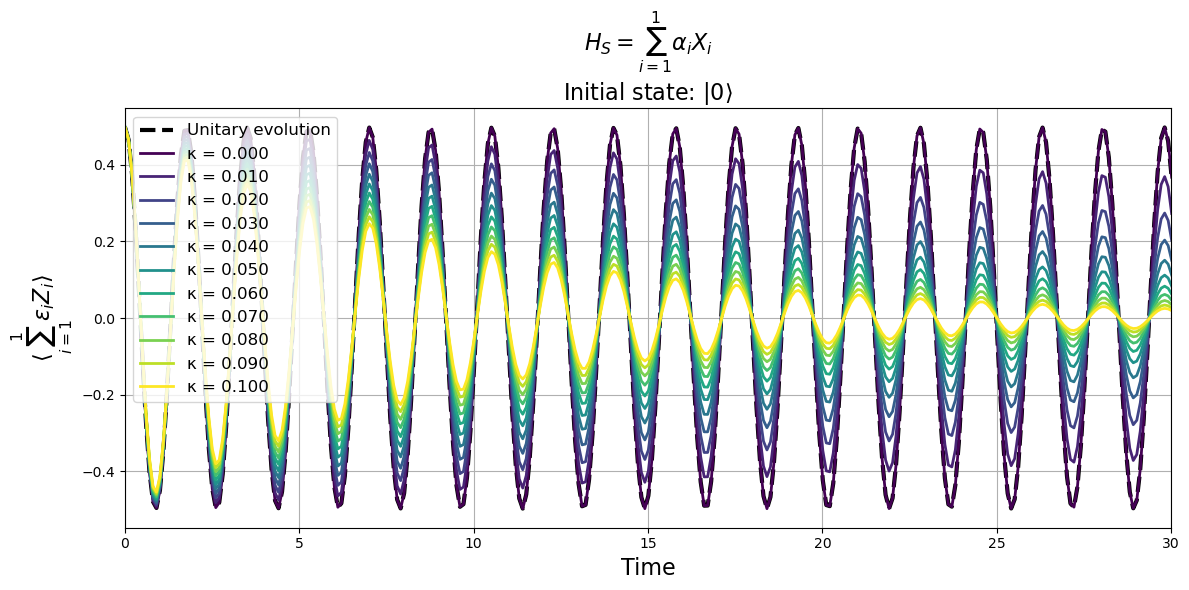

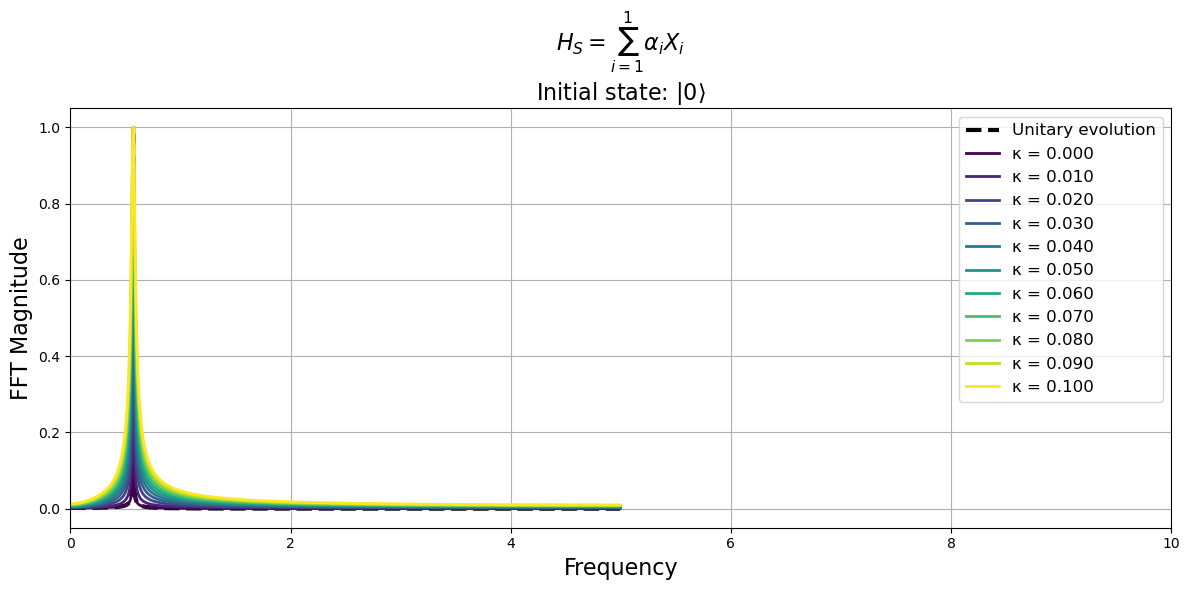

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import itertools
# Fix random seed for reproducibility
seed = 100
np.random.seed(seed)

# General parameters
tlist = np.linspace(0, 200, 2000)
save_base_path = fr"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\c_ops\f{seed}"
os.makedirs(save_base_path, exist_ok=True)

import numpy as np
from scipy.signal import savgol_filter, find_peaks
selected_indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,100,101]

def peak_frequency(freqs, fft_vals, height=0.01 , distance=10):
    """
    Returns only the frequencies corresponding to local maxima in the normalized FFT magnitude.

    Parameters:
    freqs (np.ndarray): Array of frequency values (Hz).
    fft_vals (np.ndarray): Array of corresponding FFT values (can be complex).
    height (float, optional): Minimum normalized height (0-1) of peaks to consider.
    distance (int, optional): Minimum number of samples between peaks.

    Returns:
    np.ndarray: Frequencies where local maxima occur, unsorted.
    """
    # Normalize the FFT magnitudes
    abs_fft = np.abs(fft_vals)
    normalized_fft = abs_fft / np.max(abs_fft)
    
    # Find peaks - only need to call find_peaks once
    peaks_idx, _ = find_peaks(normalized_fft, height=height, distance=distance)
    
    return freqs[peaks_idx]

def match_by_leading_digits(peaks1, peaks2, digits=2):
    """
    Match peaks1 -> peaks2 by leading digits and exponent, with flexibility:
    1. First try with `digits` significant digits.
    2. If some peaks are unmatched, try with 1 significant digit.
    3. If still unmatched, allow ±1 difference in leading digits.
    Returns list of (p1, p2) matched pairs.
    """
    def key_sig_exp(x, d):
        if x == 0:
            return ('0'*d, 0)
        s = f"{abs(x):.{d+6}e}"  # scientific notation with extra precision
        mantissa_str, exp_str = s.split('e')
        mantissa = mantissa_str.replace('.', '')[:d]
        exponent = int(exp_str)
        return (mantissa, exponent)

    def try_match(pks1, pks2, d):
        # Basic exact matching by mantissa + exponent
        idx_map = {}
        for i, p2 in enumerate(pks2):
            idx_map.setdefault(key_sig_exp(p2, d), []).append((i, p2))

        matches = []
        used = set()
        unmatched1 = []
        for p1 in pks1:
            key = key_sig_exp(p1, d)
            if key in idx_map:
                for i, p2 in idx_map[key]:
                    if i not in used:
                        matches.append((p1, p2))
                        used.add(i)
                        break
                else:
                    unmatched1.append(p1)
            else:
                unmatched1.append(p1)
        return matches, unmatched1, used

    # 1. Try initial digits
    matches, unmatched1, used2 = try_match(peaks1, peaks2, digits)

    if unmatched1:
        # 2. Retry with 1 significant digit
        extra_matches, unmatched1, used2_extra = try_match(unmatched1, [p2 for i,p2 in enumerate(peaks2) if i not in used2], 1)
        matches.extend(extra_matches)
        used2.update(used2_extra)

    if unmatched1:
        # 3. Allow ±1 difference in first digit of mantissa (for remaining unmatched)
        remaining2 = [p2 for i,p2 in enumerate(peaks2) if i not in used2]
        for p1 in unmatched1:
            m1, e1 = key_sig_exp(p1, 1)
            found = False
            for i, p2 in enumerate(remaining2):
                m2, e2 = key_sig_exp(p2, 1)
                # Check same exponent and mantissa differs by ±1 in integer value
                if e1 == e2 and abs(int(m1) - int(m2)) <= 1:
                    matches.append((p1, p2))
                    remaining2.pop(i)
                    found = True
                    break
            if not found:
                # optionally append None to indicate unmatched
                matches.append((p1, None))

    return matches

def minimal_relative_error(peaks1, peaks2,matches):
    relative_error_avg = 0
    if not matches:
        n1, n2 = len(peaks1), len(peaks2)
        # Use the Hungarian algorithm (optimal assignment) for longer or unequal lists
        n = max(n1, n2)
        # Create square cost matrix with padded dummy values (cost = large)
        cost_matrix = np.full((n, n), fill_value=1e6)
        for i in range(n1):
            for j in range(n2):
                denom = abs(peaks2[j]) if abs(peaks2[j]) > 1e-6 else 1e-6  # avoid division by zero
                cost_matrix[i, j] = (abs(peaks1[i] - peaks2[j]) / denom) * 100  # percentage error

        # Apply Hungarian algorithm to find the minimal total error assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        relative_errors = [cost_matrix[i, j] for i, j in zip(row_ind, col_ind) if i < n1 and j < n2]
        relative_error_avg = np.mean(relative_errors)
        return relative_error_avg
    else:
        # Calculate the average relative error for matched pairs
        for u, v in matches:
            if v is None:
                continue
            aux = (abs(u - v) / abs(v)) * 100
            relative_error_avg += aux
        return relative_error_avg/len(matches)

kappas = np.linspace(0, 0.1, num=101)



for num_qubits in [1,2,3,4,5]:
     #Parameters
    epsilon = np.random.uniform(0.3, 1, num_qubits)  
    alpha_list = np.random.uniform(1,5, 15)
    beta_list = np.random.uniform(1, 5, 15)
    min_value = np.min(np.concatenate((alpha_list, beta_list)))

    # Normalize both arrays so that the smallest entry across both becomes 1
    alpha= alpha_list / min_value
    beta = beta_list / min_value
    alpha_1= alpha_list / np.min(alpha_list)   
    # Operator constructors
    def build_op(op_qubit, pos):
        ops = [qeye(2) for _ in range(num_qubits)]
        ops[pos] = op_qubit
        return tensor(ops)

    X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
    Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
    Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]

    # Observable operators
    observable_op_1 = sum(epsilon[i] * Z_ops[i] for i in range(num_qubits))
    observable_op_2 = sum(epsilon[i] * X_ops[i] for i in range(num_qubits))

    # Hamiltonians
    Hs_1 = sum(alpha[i] * X_ops[i] for i in range(num_qubits))
    Hs_2 = sum(alpha[i] * X_ops[i] * X_ops[i+1] + beta[i] * Y_ops[i] * Y_ops[i+1] for i in range(num_qubits - 1))
    Hs_3 = sum(alpha[i] * Z_ops[i] for i in range(num_qubits))

    # Initial states
    zero_state = tensor([basis(2, 0) for _ in range(num_qubits)])
    one_state = tensor([basis(2, 1)] + [basis(2, 0) for _ in range(1, num_qubits)])
    psi_1 = zero_state.unit()
    psi_2 = one_state.unit()
    psi_3 = (zero_state + one_state).unit()
    for i in range(2):
        results_list = []
        ket_zero = "0" * num_qubits
        ket_mixed = "1" + "0" * (num_qubits - 1)

        # Hamiltonian and initial state setup
        if i == 0:
            Hs = Hs_1
            state = psi_1
            observable_op = observable_op_1
            bath_basis = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_i X_i$' '\n'
                r'Initial state: $|%s\rangle$' % (num_qubits, ket_zero)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits

        elif i == 1:
            if num_qubits == 1:
                continue
            Hs = Hs_2
            state = psi_2
            observable_op = observable_op_1
            bath_basis = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_{i} X_i X_{i+1} + \beta_{i} Y_i Y_{i+1}$' '\n'
                r'Initial state: $|%s\rangle$' % (num_qubits - 1, ket_mixed)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits

        else:
            Hs = Hs_3
            def get_initial_state(num_qubits):
                if num_qubits == 1:
                    return (basis(2, 0) + basis(2, 1)).unit()  # |+⟩
                else:
                    # Producto de |+⟩ en cada qubit
                    plus = (basis(2, 0) + basis(2, 1)).unit()
                    return tensor([plus] * num_qubits)
            state = get_initial_state(num_qubits)
            observable_op = observable_op_2
            bath_basis = X_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_i Z_i$' '\n'
                r'Initial state: $\dfrac{1}{\sqrt{2}} (|%s\rangle + |%s\rangle)$' 
                % (num_qubits, ket_zero, ket_mixed)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i X_i \rangle$' % num_qubits
            

        # Unitary evolution (no collapse)
        result_unitary = sesolve(Hs, state, tlist)
        observable_vals_unitary = [expect(observable_op, st) for st in result_unitary.states]
        fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
        fft_unitary = fft_unitary / np.max(fft_unitary)
        freqs_unitary = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
        mask_pos = freqs_unitary >= 0
        fft_unitary = fft_unitary[mask_pos]
        freqs_unitary = freqs_unitary[mask_pos]

        # Plot time evolution
        plt.figure(figsize=(12, 6))
        plt.plot(tlist, observable_vals_unitary, 'k--', lw=3, label='Unitary evolution')

        fft_kappas = []
        freqs_kappas = []
        labels_kappas = []

        for idx_kappa, kappa_val in enumerate(kappas):
            # Collapse operators scaled by coupling strength
            c_ops = [np.sqrt(kappa_val) * op for op in bath_basis]

            result = mesolve(Hs, state, tlist, c_ops)
            observable_vals = [expect(observable_op, st) for st in result.states]

            if idx_kappa in selected_indices:
                color = plt.cm.viridis(idx_kappa / (len(kappas) - 1))
                plt.plot(tlist, observable_vals, lw=2, label=f'κ = {kappa_val:.3f}', color=color)

            # FFT
            energy_fft = np.abs(np.fft.fft(observable_vals))
            freqs = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
            mask_pos = freqs >= 0
            freqs = freqs[mask_pos]
            energy_fft = energy_fft[mask_pos]
            energy_fft = energy_fft / np.max(energy_fft)

            fft_kappas.append(energy_fft)
            freqs_kappas.append(freqs)
            labels_kappas.append(f'κ = {kappa_val:.3f}')

            freq_peak = peak_frequency(freqs, energy_fft)
            freq_peak_unitary = peak_frequency(freqs_unitary, fft_unitary)


            

            if len(freq_peak) and len(freq_peak_unitary):
                matches = match_by_leading_digits(freq_peak, freq_peak_unitary, digits=2)
                relative_error_avg = minimal_relative_error(freq_peak, freq_peak_unitary,matches)
            else:
                relative_error_avg = 100

            if relative_error_avg >= 100:
                relative_error_avg = 100
            results_list.append({
                "kappa": kappa_val,
                "Hamiltonian": ham_title,
                "freq_peak": freq_peak,
                "freq_peak_unitary": freq_peak_unitary,
                "relative_error": relative_error_avg
            })

        # Save time evolution figure
        plt.title(ham_title, fontsize=16)
        plt.xlim(0, 30)
        plt.xlabel('Time', fontsize=16)
        plt.ylabel(obs_label, fontsize=16)
        plt.grid(True)
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()

        # Plot FFT comparison
        plt.figure(figsize=(12, 6))
        plt.plot(freqs_unitary, fft_unitary, 'k--', lw=3, label='Unitary evolution')
        plt.xlim(0, 10)

        for idx, (energy_fft, freqs, label) in enumerate(zip(fft_kappas, freqs_kappas, labels_kappas)):
            if idx in selected_indices:
                color = plt.cm.viridis(idx / (len(fft_kappas) - 1))
                plt.plot(freqs, energy_fft, lw=2, label=label, color=color)

        plt.title(ham_title, fontsize=16)
        plt.xlabel('Frequency', fontsize=16)
        plt.ylabel('FFT Magnitude', fontsize=16)
        plt.grid(True)
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'fft_{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()

        csv_path = os.path.join(save_base_path, f'df_{num_qubits}_{i}.csv')

        df = pd.DataFrame(results_list)

        if os.path.exists(csv_path):
            df_old = pd.read_csv(csv_path)
            # Concatenar y eliminar duplicados usando solo la columna 'alpha'
            df_combined = pd.concat([df_old, df], ignore_index=True)
            df_combined.drop_duplicates(subset=['kappa'], inplace=True)
            df_combined.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, index=False)

        styled_df = (df.style
                    .set_caption(f"Results for {num_qubits} Qubits")
                    .set_table_styles([{
                        'selector': 'thead th',
                        'props': [('background-color', '#1F77B4'), ('color', 'white')]
                    }]))
        display(styled_df)


## Plotting the results

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

seed = 100
base_path = fr"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\c_ops\f{seed}"

i_range = range(1, 6)
j_range = range(2)

max_kappa =1
num_points = 200

grouped_data = {j: [] for j in j_range}
grouped_frequency_counts = {j: [] for j in j_range}
# ...
for j in j_range:
    for i in i_range:
        filename = f"df_{i}_{j}.csv"
        file_path = os.path.join(base_path, filename)

        try:
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)

            if df.shape[1] < 2:
                print(f"File {filename} has insufficient columns.")
                continue

            # Detectar primer punto donde difiere la longitud de arrays en penúltima y última columna
            penultima = df.iloc[:, -2]
            ultima = df.iloc[:, -1]
            x_diff = None
            for xv, arr1, arr2 in zip(df.iloc[:, 0], penultima, ultima):
                try:
                    len1 = len(eval(arr1)) if isinstance(arr1, str) else (len(arr1) if hasattr(arr1, '__len__') else 1)
                    len2 = len(eval(arr2)) if isinstance(arr2, str) else (len(arr2) if hasattr(arr2, '__len__') else 1)
                except:
                    len1, len2 = 0, 0
                if len1 != len2:
                    x_diff = xv
                    break

            # For the error plot
            x = df.iloc[:, 0]
            y = df.iloc[:, -1]

            y_clean = y.fillna(100)
            y_clean = np.where((y_clean > 100) | (pd.isnull(y_clean)), 100, y_clean)

            if x.max() < max_kappa:
                x_extended = np.linspace(x.min(), max_kappa, num_points)
                y_extended = np.interp(x_extended, x, y_clean, left=100, right=100)
                x = x_extended
                y_clean = y_extended

            grouped_data[j].append((x, y_clean, f"{i} qubits", x_diff))

            # For the frequency count plot
            x_freq = df.iloc[:, 0]
            freq_col = df.iloc[:, 2]

            frequency_counts = []
            for cell in freq_col:
                if isinstance(cell, str):
                    try:
                        freq_list = eval(cell)
                        count = len(freq_list) if isinstance(freq_list, list) else 1
                    except:
                        count = 0
                elif pd.isna(cell):
                    count = 0
                else:
                    count = 1
                frequency_counts.append(count)
            frequency_counts = np.array(frequency_counts)

            if x_freq.max() < max_kappa:
                x_extended = np.linspace(x_freq.min(), max_kappa, num_points)
                freq_counts_extended = np.interp(x_extended, x_freq, frequency_counts, left=0, right=0)
                x_freq = x_extended
                frequency_counts = freq_counts_extended

            grouped_frequency_counts[j].append((x_freq, frequency_counts, f"{i} qubits"))

        except Exception as e:
            print(f"Could not read file {file_path}: {e}")

# Plot Relative Error (%) vs kappa
for j in j_range:
    plt.figure(figsize=(10, 6))
    plt.xlim(0, max_kappa)
    if max_kappa == 0.1:
        plt.ylim(0, 1)

    if not grouped_data[j]:
        print(f"No data for j = {j}")
        continue

    for x, y, label, x_diff in grouped_data[j]:
        plt.plot(x, y, label=label)
        # Línea vertical donde cambia la longitud de arrays
        if x_diff is not None:
            plt.axvline(x=x_diff, color='red', linestyle='--', linewidth=1)

    plt.xlabel("Coupling strength ($\kappa$)")
    if i == 1:
        plt.ylabel(r"Relative Error (%)  $\langle  \epsilon_1 Z_1 \rangle$")
    else:
        plt.ylabel(
            rf"Relative Error (%)  $\langle \sum_{{i=1}}^{i} \epsilon_i Z_i \rangle$"
        )

    if j == 0:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i X_i$')
    elif j == 1:
        plt.title(r'$H_S = \sum_{i=1}^{N-1} \alpha_i X_i X_{i+1} + \beta_i Y_i Y_{i+1}$')
    else:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i Z_i$')
    plt.axvline(x=0.1, color='black', linestyle='--', linewidth=1, label=r'$x=0.1$')
    plt.axhline(y=10, color='black', linestyle='--', linewidth=1, label=r'$y=10$')
    plt.legend(loc='upper right')
    plt.xlim(0, max_kappa)
    plt.ylim(0, 102)

    plt.grid(True)
    plt.tight_layout()
    if max_kappa == 0.1:
        plt.savefig(os.path.join(base_path, f'output_c_ops_{j}_zoomed.pdf'))
    else:
        plt.savefig(os.path.join(base_path, f'output_c_ops_{j}.pdf'))
    plt.show()


# Drude Lorentz Model

In the theory of open quantum systems, a bosonic environment is often characterized by its **spectral density** $ J(\omega)$, which describes how different frequency modes of the bath couple to the system.

The **Drude-Lorentz spectral density** is a widely used model that captures dissipation with a finite memory time. It is particularly useful for describing condensed-phase environments such as solvents, phonon baths, or thermal reservoirs with exponential decay of correlations.

---

## Spectral Density Function

The Drude-Lorentz spectral density is defined as:

$$
J(\omega) = \frac{2 \lambda \gamma \omega}{\omega^2 + \gamma^2}
$$

---

### Meaning of each term:

- $ \omega $: Frequency of the environmental (bath) mode.
- $ \lambda $: **Reorganization energy** or **coupling strength**. This parameter quantifies the total coupling between the system and the bath.
- $ \gamma $: **Cutoff frequency** or **bath relaxation rate**. It sets the timescale for the decay of bath correlations, with $\tau_c = \gamma^{-1} $ being the correlation time.
- $ J(\omega) $: Spectral density, describing how strongly each frequency component of the bath couples to the system.

---

## Physical Interpretation

- At low frequencies $ (\omega \ll \gamma)$,$ J(\omega) \approx \frac{2 \lambda \omega}{\gamma} $, showing **Ohmic behavior**.
- At high frequencies $ (\omega \gg \gamma) $, the spectral density decays as $ J(\omega) \propto \omega^{-1} $, ensuring that high-frequency contributions are suppressed.

This model allows for **non-Markovian dynamics** due to the finite bath memory time, making it a versatile and realistic choice for simulations involving quantum dissipation.

---
# Analysis of the results in function of the parameters

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
from qutip import *
import os
import re
from qutip.solver import Options
seed = 102
np.random.seed(seed)  # For reproducibility
tlist = np.linspace(0, 200, 2000)
save_base_path = rf"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f{seed}"
os.makedirs(save_base_path, exist_ok=True)
# Parameters 

from scipy.signal import savgol_filter, find_peaks
#selected_indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,100,101]
selected_indices = [0, 1,2,3,4,5,6,7,8,9,10,11]
# lambda range 

#lambdas = np.linspace(0, 0.1, num=101)  
lambdas= [0, 0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
import itertools
from scipy.optimize import linear_sum_assignment

max_depth =2
Nk = 2
gamma = 0.1
T = 0.1
def peak_frequency(freqs, fft_vals, height=0.01 , distance=10):
    """
    Returns only the frequencies corresponding to local maxima in the normalized FFT magnitude.

    Parameters:
    freqs (np.ndarray): Array of frequency values (Hz).
    fft_vals (np.ndarray): Array of corresponding FFT values (can be complex).
    height (float, optional): Minimum normalized height (0-1) of peaks to consider.
    distance (int, optional): Minimum number of samples between peaks.

    Returns:
    np.ndarray: Frequencies where local maxima occur, unsorted.
    """
    # Normalize the FFT magnitudes
    abs_fft = np.abs(fft_vals)
    normalized_fft = abs_fft / np.max(abs_fft)
    
    # Find peaks - only need to call find_peaks once
    peaks_idx, _ = find_peaks(normalized_fft, height=height, distance=distance)
    
    return freqs[peaks_idx]

def match_by_leading_digits(peaks1, peaks2, digits=2):
    """
    Match peaks1 -> peaks2 by leading digits and exponent, with flexibility:
    1. First try with `digits` significant digits.
    2. If some peaks are unmatched, try with 1 significant digit.
    3. If still unmatched, allow ±1 difference in leading digits.
    Returns list of (p1, p2) matched pairs.
    """
    def key_sig_exp(x, d):
        if x == 0:
            return ('0'*d, 0)
        s = f"{abs(x):.{d+6}e}"  # scientific notation with extra precision
        mantissa_str, exp_str = s.split('e')
        mantissa = mantissa_str.replace('.', '')[:d]
        exponent = int(exp_str)
        return (mantissa, exponent)

    def try_match(pks1, pks2, d):
        # Basic exact matching by mantissa + exponent
        idx_map = {}
        for i, p2 in enumerate(pks2):
            idx_map.setdefault(key_sig_exp(p2, d), []).append((i, p2))

        matches = []
        used = set()
        unmatched1 = []
        for p1 in pks1:
            key = key_sig_exp(p1, d)
            if key in idx_map:
                for i, p2 in idx_map[key]:
                    if i not in used:
                        matches.append((p1, p2))
                        used.add(i)
                        break
                else:
                    unmatched1.append(p1)
            else:
                unmatched1.append(p1)
        return matches, unmatched1, used

    # 1. Try initial digits
    matches, unmatched1, used2 = try_match(peaks1, peaks2, digits)

    if unmatched1:
        # 2. Retry with 1 significant digit
        extra_matches, unmatched1, used2_extra = try_match(unmatched1, [p2 for i,p2 in enumerate(peaks2) if i not in used2], 1)
        matches.extend(extra_matches)
        used2.update(used2_extra)

    if unmatched1:
        # 3. Allow ±1 difference in first digit of mantissa (for remaining unmatched)
        remaining2 = [p2 for i,p2 in enumerate(peaks2) if i not in used2]
        for p1 in unmatched1:
            m1, e1 = key_sig_exp(p1, 1)
            found = False
            for i, p2 in enumerate(remaining2):
                m2, e2 = key_sig_exp(p2, 1)
                # Check same exponent and mantissa differs by ±1 in integer value
                if e1 == e2 and abs(int(m1) - int(m2)) <= 1:
                    matches.append((p1, p2))
                    remaining2.pop(i)
                    found = True
                    break
            if not found:
                # optionally append None to indicate unmatched
                matches.append((p1, None))

    return matches

def minimal_relative_error(peaks1, peaks2,matches):
    relative_error_avg = 0
    if not matches:
        n1, n2 = len(peaks1), len(peaks2)
        # Use the Hungarian algorithm (optimal assignment) for longer or unequal lists
        n = max(n1, n2)
        # Create square cost matrix with padded dummy values (cost = large)
        cost_matrix = np.full((n, n), fill_value=1e6)
        for i in range(n1):
            for j in range(n2):
                denom = abs(peaks2[j]) if abs(peaks2[j]) > 1e-6 else 1e-6  # avoid division by zero
                cost_matrix[i, j] = (abs(peaks1[i] - peaks2[j]) / denom) * 100  # percentage error

        # Apply Hungarian algorithm to find the minimal total error assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        relative_errors = [cost_matrix[i, j] for i, j in zip(row_ind, col_ind) if i < n1 and j < n2]
        relative_error_avg = np.mean(relative_errors)
        return relative_error_avg
    else:
        # Calculate the average relative error for matched pairs
        for u, v in matches:
            if v is None:
                continue
            aux = (abs(u - v) / abs(v)) * 100
            relative_error_avg += aux
        return relative_error_avg/len(matches)



for num_qubits in [1,2,3,4,5]:
    #Parameters
    epsilon = np.random.uniform(0.7, 1, num_qubits)  
    alpha_list = np.random.uniform(1,5, num_qubits)
    beta_list = np.random.uniform(1, 5, num_qubits)
    min_value = np.min(np.concatenate((alpha_list, beta_list)))

    # Normalize both arrays so that the smallest entry across both becomes 1
    alpha= alpha_list / min_value
    beta = beta_list / min_value
    alpha_1= alpha_list / np.min(alpha_list)


    def build_op(op_qubit, pos, num_qubits):
        ops = [qeye(2) for _ in range(num_qubits)]
        ops[pos] = op_qubit
        return tensor(ops)
    X_ops = [build_op(sigmax(), i,num_qubits) for i in range(num_qubits)]
    Y_ops = [build_op(sigmay(), i,num_qubits) for i in range(num_qubits)]
    Z_ops = [build_op(sigmaz(), i,num_qubits) for i in range(num_qubits)]

    observable_op_1 = sum(epsilon[i] * Z_ops[i] for i in range(num_qubits))
    observable_op_2 = sum(epsilon[i] * X_ops[i] for i in range(num_qubits))

    Hs_1 = sum(alpha_1[i] * X_ops[i] for i in range(num_qubits))
    Hs_2 = sum(alpha[i] * X_ops[i] * X_ops[i+1] + beta[i] * Y_ops[i] * Y_ops[i+1] for i in range(num_qubits-1))
    #Hs_3 = sum(alpha[i] * Z_ops[i] for i in range(num_qubits))

    zero_state = tensor([basis(2, 0) for _ in range(num_qubits)])
    psi = zero_state.unit()
    one_state = tensor([basis(2, 1)] + [basis(2, 0) for _ in range(1, num_qubits)])
    #psi_3 = (zero_state + one_state).unit()
    psi_2 = one_state.unit()

    results_list = []
    for i in range(2):
        results_list = []
        ket_zero = "0" * num_qubits
        ket_mixed = "1" + "0" * (num_qubits - 1)
        
        if i == 0:
            Hs = Hs_1
            state = psi
            observable_op = observable_op_1
            bath_ops = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_i X_i$' '\n'
                r'Initial state: $|%s\rangle$''\n'
                % (num_qubits, ket_zero)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits

        elif i == 1:
            if num_qubits == 1:
                continue
            Hs = Hs_2
            state = psi_2
            observable_op = observable_op_1
            bath_ops = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_{i} X_i X_{i+1} + \beta_{i} Y_i Y_{i+1}$' '\n'
                r'Initial state: $|%s\rangle$'
                % (num_qubits - 1, ket_mixed)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits


        # Unitary
        result_unitary = sesolve(Hs, state, tlist)
        observable_vals_unitary = [expect(observable_op, st) for st in result_unitary.states]
        fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
        freqs_unitary = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
        pos_mask_unitary = freqs_unitary >= 0
        fft_unitary = fft_unitary[pos_mask_unitary]
        fft_unitary = fft_unitary / np.max(fft_unitary)
        freqs_unitary = freqs_unitary[pos_mask_unitary]
        

        
        plt.figure(figsize=(12, 6))
        plt.plot(tlist, observable_vals_unitary, 'k--', lw=3, label='Unitary evolution')

        fft_lambdas = []
        freqs_lambdas = []
        labels_lambdas = []

        for idx_lambda, lambda_d in enumerate(lambdas):
            baths = [DrudeLorentzBath(op, lambda_d, gamma, T, Nk) for op in bath_ops]
            solver = HEOMSolver(Hs, baths, max_depth=max_depth, options=Options(nsteps=10000, progress_bar=None))
            result = solver.run(ket2dm(state), tlist)
            observable_vals = [expect(observable_op, state.ptrace(list(range(num_qubits)))) for state in result.states]
            
            # Gradient color for each lambda
            color = plt.cm.viridis(idx_lambda / (len(lambdas) - 1))
            if idx_lambda in selected_indices:
                plt.plot(tlist, observable_vals, lw=2, label=f'λ = {lambda_d:.3f}', color=color)

            # FFT para cada lambda
            energy_fft = np.abs(np.fft.fft(observable_vals))
            freqs = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
            pos_mask = freqs >= 0
            freqs = freqs[pos_mask]
            energy_fft = energy_fft[pos_mask]
            energy_fft = energy_fft / np.max(energy_fft)   
            fft_lambdas.append(energy_fft)
            freqs_lambdas.append(freqs)
            labels_lambdas.append(f'λ = {lambda_d:.3f}')

            freq_peak = peak_frequency(freqs, energy_fft)
            
            freq_peak_unitary =peak_frequency(freqs_unitary, fft_unitary)
            
            
            if len(freq_peak) > 0 and len(freq_peak_unitary) > 0:
                freq_peak = np.sort(freq_peak)
                freq_peak_unitary = np.sort(freq_peak_unitary)
                matches = match_by_leading_digits(freq_peak, freq_peak_unitary, digits=2)
                relative_error_avg = minimal_relative_error(freq_peak, freq_peak_unitary,matches)
            else:
                relative_error_avg = 100

            print(f"Lambda: {lambda_d}, Relative Error: {relative_error_avg:.2f}% , num_qubits: {num_qubits}, Hamiltonian: {i}")

            if relative_error_avg >= 100:
                print(f"Warning: Relative error for lambda {lambda_d} is 100% or more, skipping further analysis.")
                break


            results_list.append({
                "lambda_d": lambda_d,
                "freq_peak": freq_peak,
                "freq_peak_unitary": freq_peak_unitary,
                "relative_error": relative_error_avg,
            })

        # graphics 
        plt.title(ham_title, fontsize=16)
        plt.xlim(0,30)
        plt.xlabel('Time',fontsize=16)
        plt.ylabel(obs_label,fontsize=16)
        plt.grid(True)
        plt.legend(loc="upper right", fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()


        plt.figure(figsize=(12, 6))
        plt.plot(freqs_unitary, fft_unitary, 'k--', lw=3, label='Unitary evolution')

        cmap = plt.cm.viridis
        num_lambdas = len(fft_lambdas)
        for idx, (energy_fft, freqs, label) in enumerate(zip(fft_lambdas, freqs_lambdas, labels_lambdas)):
            if idx in selected_indices:
                color = cmap(idx / (num_lambdas - 1))
                plt.plot(freqs, energy_fft, lw=2, label=label, color=color)

        plt.title(ham_title, fontsize=16)
        plt.xlim(0,5)
        plt.xlabel('Frequency', fontsize=16)
        plt.ylabel('FFT Magnitude', fontsize=16)
        plt.grid(True)
        plt.legend(loc="upper right", fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'fft_{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()
        csv_path = os.path.join(save_base_path, f'df_{num_qubits}_{i}.csv')

        df = pd.DataFrame(results_list)

        if os.path.exists(csv_path):
            df_old = pd.read_csv(csv_path)
            # Concatenar y eliminar duplicados usando solo la columna 'alpha'
            df_combined = pd.concat([df_old, df], ignore_index=True)
            df_combined.drop_duplicates(subset=['lambda_d'], inplace=True)
            df_combined.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, index=False)

        styled_df = (df.style
                    .set_caption(f"Results for {num_qubits} Qubits")
                    .set_table_styles([{
                        'selector': 'thead th',
                        'props': [('background-color', '#1F77B4'), ('color', 'white')]
                    }]))
        display(styled_df)


## Ploting the results

File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f1350\df_1_0.csv
File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f1350\df_2_0.csv
File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f1350\df_3_0.csv
File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f1350\df_4_0.csv
File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f1350\df_5_0.csv
File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f1350\df_1_1.csv
No data for j = 0


<Figure size 1000x600 with 0 Axes>

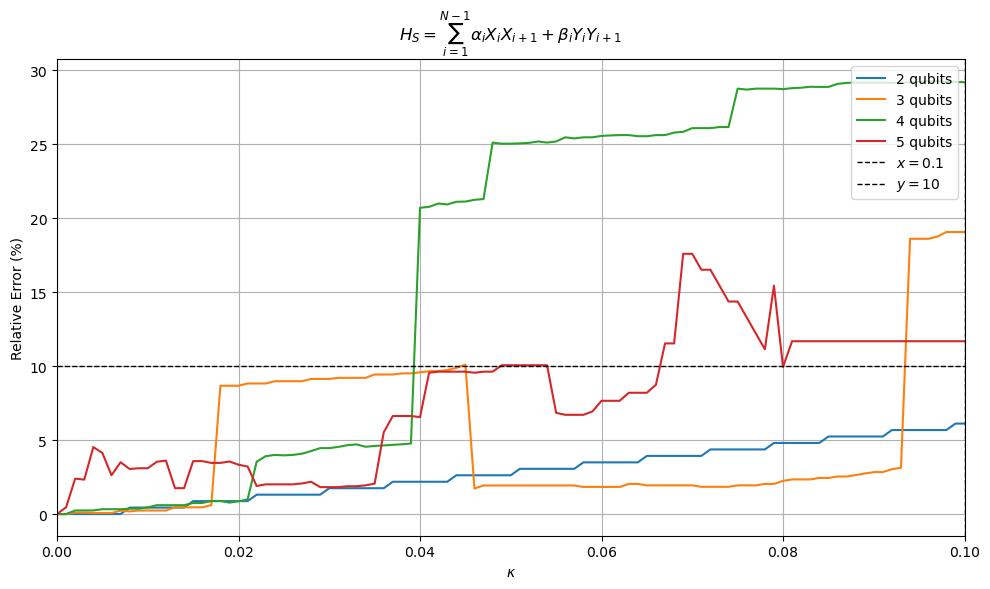

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
seed = 1350
# Base folder where files are located
base_path = fr"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_Lorentz\f{seed}"

# i from 1 to 5, j from 0 to 2
i_range = range(1, 6)
j_range = range(2)

# Desired maximum kappa for plots
max_kappa = 0.1 # or adjust to your expected max
num_points = 200  # resolution for interpolation / extension

# Initialize grouped data storage
grouped_data = {j: [] for j in j_range}

# Read all relevant files
for j in j_range:
    for i in i_range:
        filename = f"df_{i}_{j}.csv"
        file_path = os.path.join(base_path, filename)

        try:
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)

            if df.shape[1] < 2:
                print(f"File {filename} has insufficient columns.")
                continue

            x = df.iloc[:, 0]
            y = df.iloc[:, -1]

            # Replace None, NaN, or values > 100 with 100
            y_clean = y.fillna(100)
            y_clean = np.where((y_clean > 100) | (pd.isnull(y_clean)), 100, y_clean)

            # Ensure values extend to max_kappa with y=100
            if x.max() < max_kappa:
                x_extended = np.linspace(x.min(), max_kappa, num_points)
                y_extended = np.interp(x_extended, x, y_clean, left=100, right=100)
                x = x_extended
                y_clean = y_extended

            grouped_data[j].append((x, y_clean, f"{i} qubits"))

        except Exception as e:
            print(f"Could not read file {file_path}: {e}")

# Plotting
for j in j_range:
    plt.figure(figsize=(10, 6))

    if not grouped_data[j]:
        print(f"No data for j = {j}")
        continue
    plt.xlim(0, max_kappa)
    for x, y, label in grouped_data[j]:
        plt.plot(x, y, label=label)
    plt.xlabel("$\\kappa$")
    plt.ylabel("Relative Error (%)")
    if j == 0:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i X_i$')
    elif j == 1:
        plt.title(r'$H_S = \sum_{i=1}^{N-1} \alpha_i X_i X_{i+1} + \beta_i Y_i Y_{i+1}$')
    else:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i Z_i$')
    plt.axvline(x=0.1, color='black', linestyle='--', linewidth=1, label=r'$x=0.1$')

    plt.axhline(y=10, color='black', linestyle='--', linewidth=1, label=r'$y=10$')
    plt.legend(loc='upper right')


    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(base_path, f'output_drude_{j}_{max_kappa}.pdf'))
    plt.show()



In [ ]:
import pandas as pd
import os
from IPython.display import display

# Parámetros: elige el archivo que quieras ver
i = 3  # cambia por el valor de i que quieras
j = 1  # cambia por el valor de j que quieras

# Ruta base
base_path = r"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\Drude_lorentz"
filename = f"df_{i}_{j}.csv"
file_path = os.path.join(base_path, filename)

# Leer y mostrar
if os.path.exists(file_path):
    try:
        df = pd.read_csv(file_path)

        if df.empty:
            print(f"{filename} está vacío.")
        else:
            styled_df = (
                df.style
                .set_caption(f"Contenido de {filename}")
                .set_table_styles([{
                    'selector': 'thead th',
                    'props': [('background-color', '#1F77B4'), ('color', 'white')]
                }])
            )
            display(styled_df)

    except Exception as e:
        print(f"Error al leer {filename}: {e}")
else:
    print(f"No se encontró el archivo: {filename}")
print(df.columns.tolist())


# Ohmic Model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import qutip as qt
from qutip.solver.heom import DrudeLorentzBath, HEOMSolver
import numpy as np
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import linear_sum_assignment

# Fix random seed for reproducibility
seed = 678
np.random.seed(seed)

# General parameters
tlist = np.linspace(0, 200, 2000)
save_base_path = fr"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\ohmic\f{seed}"
os.makedirs(save_base_path, exist_ok=True)

max_depth = 1

selected_indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,100]

def peak_frequency(freqs, fft_vals, height=0.01 , distance=10):
    """
    Returns only the frequencies corresponding to local maxima in the normalized FFT magnitude.

    Parameters:
    freqs (np.ndarray): Array of frequency values (Hz).
    fft_vals (np.ndarray): Array of corresponding FFT values (can be complex).
    height (float, optional): Minimum normalized height (0-1) of peaks to consider.
    distance (int, optional): Minimum number of samples between peaks.

    Returns:
    np.ndarray: Frequencies where local maxima occur, unsorted.
    """
    # Normalize the FFT magnitudes
    abs_fft = np.abs(fft_vals)
    normalized_fft = abs_fft / np.max(abs_fft)
    
    # Find peaks - only need to call find_peaks once
    peaks_idx, _ = find_peaks(normalized_fft, height=height, distance=distance)
    
    return freqs[peaks_idx]

def match_by_leading_digits(peaks1, peaks2, digits=2):
    """
    Match peaks1 -> peaks2 by leading digits and exponent, with flexibility:
    1. First try with `digits` significant digits.
    2. If some peaks are unmatched, try with 1 significant digit.
    3. If still unmatched, allow ±1 difference in leading digits.
    Returns list of (p1, p2) matched pairs.
    """
    def key_sig_exp(x, d):
        if x == 0:
            return ('0'*d, 0)
        s = f"{abs(x):.{d+6}e}"  # scientific notation with extra precision
        mantissa_str, exp_str = s.split('e')
        mantissa = mantissa_str.replace('.', '')[:d]
        exponent = int(exp_str)
        return (mantissa, exponent)

    def try_match(pks1, pks2, d):
        # Basic exact matching by mantissa + exponent
        idx_map = {}
        for i, p2 in enumerate(pks2):
            idx_map.setdefault(key_sig_exp(p2, d), []).append((i, p2))

        matches = []
        used = set()
        unmatched1 = []
        for p1 in pks1:
            key = key_sig_exp(p1, d)
            if key in idx_map:
                for i, p2 in idx_map[key]:
                    if i not in used:
                        matches.append((p1, p2))
                        used.add(i)
                        break
                else:
                    unmatched1.append(p1)
            else:
                unmatched1.append(p1)
        return matches, unmatched1, used

    # 1. Try initial digits
    matches, unmatched1, used2 = try_match(peaks1, peaks2, digits)

    if unmatched1:
        # 2. Retry with 1 significant digit
        extra_matches, unmatched1, used2_extra = try_match(unmatched1, [p2 for i,p2 in enumerate(peaks2) if i not in used2], 1)
        matches.extend(extra_matches)
        used2.update(used2_extra)

    if unmatched1:
        # 3. Allow ±1 difference in first digit of mantissa (for remaining unmatched)
        remaining2 = [p2 for i,p2 in enumerate(peaks2) if i not in used2]
        for p1 in unmatched1:
            m1, e1 = key_sig_exp(p1, 1)
            found = False
            for i, p2 in enumerate(remaining2):
                m2, e2 = key_sig_exp(p2, 1)
                # Check same exponent and mantissa differs by ±1 in integer value
                if e1 == e2 and abs(int(m1) - int(m2)) <= 1:
                    matches.append((p1, p2))
                    remaining2.pop(i)
                    found = True
                    break
            if not found:
                # optionally append None to indicate unmatched
                matches.append((p1, None))

    return matches

def minimal_relative_error(peaks1, peaks2,matches):
    relative_error_avg = 0
    if not matches:
        n1, n2 = len(peaks1), len(peaks2)
        # Use the Hungarian algorithm (optimal assignment) for longer or unequal lists
        n = max(n1, n2)
        # Create square cost matrix with padded dummy values (cost = large)
        cost_matrix = np.full((n, n), fill_value=1e6)
        for i in range(n1):
            for j in range(n2):
                denom = abs(peaks2[j]) if abs(peaks2[j]) > 1e-6 else 1e-6  # avoid division by zero
                cost_matrix[i, j] = (abs(peaks1[i] - peaks2[j]) / denom) * 100  # percentage error

        # Apply Hungarian algorithm to find the minimal total error assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        relative_errors = [cost_matrix[i, j] for i, j in zip(row_ind, col_ind) if i < n1 and j < n2]
        relative_error_avg = np.mean(relative_errors)
        return relative_error_avg
    else:
        # Calculate the average relative error for matched pairs
        for u, v in matches:
            if v is None:
                continue
            aux = (abs(u - v) / abs(v)) * 100
            relative_error_avg += aux
        return relative_error_avg/len(matches)

alphas = np.linspace(0,0.1, num=100)

for num_qubits in [1,2,3,4,5]:
    #Parameters
    epsilon = np.random.uniform(-1, 1.5, num_qubits)  
    alpha_list = np.random.uniform(1,5, 15)
    beta_list = np.random.uniform(1, 5, 15)
    min_value = np.min(np.concatenate((alpha_list, beta_list)))

    # Normalize both arrays so that the smallest entry across both becomes 1
    alpha= alpha_list / min_value
    beta = beta_list / min_value
    alpha_1= alpha_list / np.min(alpha_list)
    # Operator constructors
    def build_op(op_qubit, pos):
        ops = [qeye(2) for _ in range(num_qubits)]
        ops[pos] = op_qubit
        return tensor(ops)
    X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
    Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
    Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]

    # Observable operators
    observable_op_1 = sum(epsilon[i] * Z_ops[i] for i in range(num_qubits))
    observable_op_2 = sum(epsilon[i] * X_ops[i] for i in range(num_qubits))

    # Hamiltonians
    Hs_1 = sum(alpha_1[i] * X_ops[i] for i in range(num_qubits))
    Hs_2 = sum(alpha[i] * X_ops[i] * X_ops[i+1] + beta[i] * Y_ops[i] * Y_ops[i+1] for i in range(num_qubits - 1))
    Hs_3 = sum(alpha[i] * Z_ops[i] for i in range(num_qubits))

    # Initial states
    zero_state = tensor([basis(2, 0) for _ in range(num_qubits)])
    one_state = tensor([basis(2, 1)] + [basis(2, 0) for _ in range(1, num_qubits)])
    psi_1 = zero_state.unit()
    psi_2 = one_state.unit()
    psi_3 = (zero_state + one_state).unit()
    for i in range(2):
        results_list = []
        ket_zero = "0" * num_qubits
        ket_mixed = "1" + "0" * (num_qubits - 1)

        # Hamiltonian and initial state setup
        if i == 0:
            Hs = Hs_1
            state = psi_1
            observable_op = observable_op_1
            bath_basis = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_i X_i$' '\n'
                r'Initial state: $|%s\rangle$' % (num_qubits, ket_zero)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits

        elif i == 1:
            if num_qubits == 1:
                continue
            Hs = Hs_2
            state = psi_2
            observable_op = observable_op_1
            bath_basis = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_{i} X_i X_{i+1} + \beta_{i} Y_i Y_{i+1}$' '\n'
                r'Initial state: $|%s\rangle$' % (num_qubits - 1, ket_mixed)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_i \rangle$' % num_qubits

        else:
            Hs = Hs_3
            def get_initial_state(num_qubits):
                if num_qubits == 1:
                    return (basis(2, 0) + basis(2, 1)).unit()  # |+⟩
                else:
                    # Producto de |+⟩ en cada qubit
                    plus = (basis(2, 0) + basis(2, 1)).unit()
                    return tensor([plus] * num_qubits)
            state = get_initial_state(num_qubits)
            observable_op = observable_op_2
            bath_basis = X_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_i Z_i$' '\n'
                r'Initial state: $\dfrac{1}{\sqrt{2}} (|%s\rangle + |%s\rangle)$' 
                % (num_qubits, ket_zero, ket_mixed)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i X_i \rangle$' % num_qubits
            

        # Unitary evolution (no collapse)
        result_unitary = sesolve(Hs, state, tlist)
        observable_vals_unitary = [expect(observable_op, st) for st in result_unitary.states]
        fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))
        freqs_unitary = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
        mask_pos = freqs_unitary >= 0
        fft_unitary = fft_unitary[mask_pos]
        fft_unitary = fft_unitary / np.max(fft_unitary)
        freqs_unitary = freqs_unitary[mask_pos]

        # Plot time evolution
        plt.figure(figsize=(12, 6))
        plt.plot(tlist, observable_vals_unitary, 'k--', lw=3, label='Unitary evolution')

        fft_alphas = []
        freqs_alphas = []
        labels_alphas = []

        for idx_alphas, alpha_val in enumerate(alphas):
            # Collapse operators scaled by coupling strength
            env = qt.OhmicEnvironment(T=0.1, alpha=alpha_val , wc=2, s=0.7)
            approx_env, info = env.approx_by_cf_fit(tlist, target_rsme=None, Nr_max=1, Ni_max=1, maxfev=1e4)
            baths = [(approx_env, op) for op in bath_basis]

            solver = HEOMSolver(Hs, baths, max_depth=max_depth, options=Options( atol=1e-6,rtol=1e-5,nsteps=5000))
            rho0 = ket2dm(state)
            result = solver.run(rho0, tlist)
            observable_vals = [expect(observable_op, st) for st in result.states]

            if idx_alphas  in selected_indices:
                color = plt.cm.viridis(idx_alphas / (len(alphas) - 1))
                plt.plot(tlist, observable_vals, lw=2, label=f'κ = {alpha_val:.3f}', color=color)

            # FFT
            energy_fft = np.abs(np.fft.fft(observable_vals))
            energy_fft = energy_fft / np.max(energy_fft)
            freqs = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
            mask_pos = freqs >= 0
            freqs = freqs[mask_pos]
            energy_fft = energy_fft[mask_pos]

            fft_alphas.append(energy_fft)
            freqs_alphas.append(freqs)
            labels_alphas.append(f'α = {alpha_val:.3f}')

            freq_peak = peak_frequency(freqs, energy_fft)
            freq_peak_unitary = peak_frequency(freqs_unitary, fft_unitary)
            matches = match_by_leading_digits(freq_peak, freq_peak_unitary, digits=2)
            if len(freq_peak) > 0 and len(freq_peak_unitary) > 0:

                relative_error_avg = minimal_relative_error(freq_peak, freq_peak_unitary,matches)
            else:
                relative_error_avg = 100




            if relative_error_avg >= 100:
                relative_error_avg = 100
                break
            print(f"We are at {num_qubits} qubits in iteration {i} with alpha {alpha_val}, and the relative error is {relative_error_avg:.2f}%")


            results_list.append({
                "alpha": alpha_val,
                "Hamiltonian": ham_title,
                "freq_peak": freq_peak,
                "freq_peak_unitary": freq_peak_unitary,
                "relative_error": relative_error_avg
            })

        # Save time evolution figure
        plt.title(ham_title, fontsize=16)
        plt.xlim(0,30)
        plt.xlabel('Time', fontsize=16)
        plt.ylabel(obs_label, fontsize=16)
        plt.grid(True)
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()

        # Plot FFT comparison
        plt.figure(figsize=(12, 6))
        plt.plot(freqs_unitary, fft_unitary, 'k--', lw=3, label='Unitary evolution')

        for idx, (energy_fft, freqs, label) in enumerate(zip(fft_alphas, freqs_alphas, labels_alphas)):
            if idx in selected_indices:
                color = plt.cm.viridis(idx / (len(fft_alphas) - 1))
                plt.plot(freqs, energy_fft, lw=2, label=label, color=color)

        plt.title(ham_title, fontsize=16)
        plt.xlabel('Frequency', fontsize=16)
        plt.ylabel('FFT Magnitude', fontsize=16)
        plt.grid(True)
        plt.legend(loc='best', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'fft_{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()


        csv_path = os.path.join(save_base_path, f'df_{num_qubits}_{i}.csv')

        df = pd.DataFrame(results_list)

        if os.path.exists(csv_path):
            df_old = pd.read_csv(csv_path)
            # Concatenar y eliminar duplicados usando solo la columna 'alpha'
            df_combined = pd.concat([df_old, df], ignore_index=True)
            df_combined.drop_duplicates(subset=['alpha'], inplace=True)
            df_combined.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, index=False)

        styled_df = (df.style
                    .set_caption(f"Results for {num_qubits} Qubits")
                    .set_table_styles([{
                        'selector': 'thead th',
                        'props': [('background-color', '#1F77B4'), ('color', 'white')]
                    }]))
        display(styled_df)



## Plotting the results

df_1_0.csv
df_2_0.csv
df_3_0.csv
df_4_0.csv
df_5_0.csv
df_1_1.csv
File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\ohmic\f676\df_1_1.csv
df_2_1.csv
df_3_1.csv
df_4_1.csv
df_5_1.csv


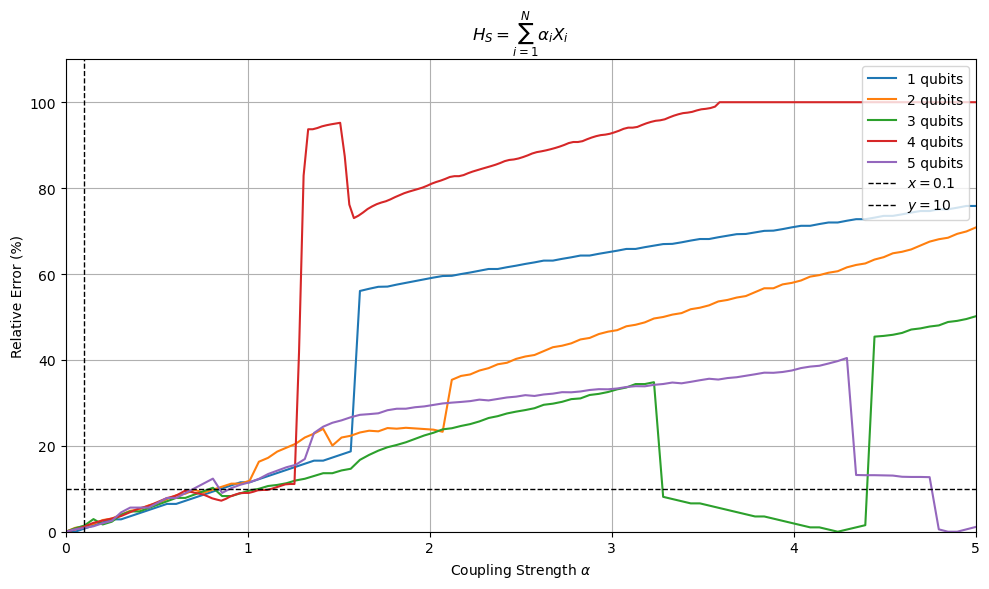

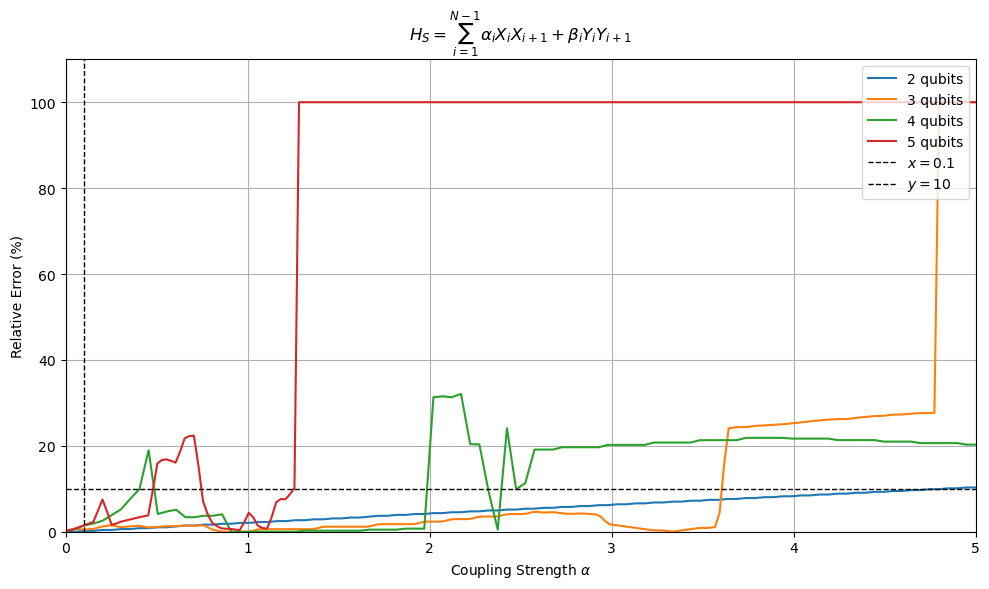

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
seed = 676
# Base folder where files are located
base_path = fr"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\ohmic\f{seed}"

# i from 1 to 5, j from 0 to 2
i_range = range(1,6)
j_range = range(2)

# Desired maximum kappa for plots
max_kappa = 5 # or adjust to your expected max
num_points = 200  # resolution for interpolation / extension

# Initialize grouped data storage
grouped_data = {j: [] for j in j_range}

# Read all relevant files
for j in j_range:
    for i in i_range:
        filename = f"df_{i}_{j}.csv"
        print(filename)
        file_path = os.path.join(base_path, filename)

        try:
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)

            if df.shape[1] < 2:
                print(f"File {filename} has insufficient columns.")
                continue

            x = df.iloc[:, 0]
            y = df.iloc[:, -1]

            # Replace None, NaN, or values > 100 with 100
            y_clean = y.fillna(100)
            y_clean = np.where((y_clean > 100) | (pd.isnull(y_clean)), 100, y_clean)

            # Ensure values extend to max_kappa with y=100
            if x.max() < max_kappa:
                x_extended = np.linspace(x.min(), max_kappa, num_points)
                y_extended = np.interp(x_extended, x, y_clean, left=100, right=100)
                x = x_extended
                y_clean = y_extended

            grouped_data[j].append((x, y_clean, f"{i} qubits"))

        except Exception as e:
            print(f"Could not read file {file_path}: {e}")

# Plotting
for j in j_range:
    plt.figure(figsize=(10, 6))
    if not grouped_data[j]:
        print(f"No data for j = {j}")
        continue

    for x, y, label in grouped_data[j]:
        plt.plot(x, y, label=label)

    plt.xlabel("Coupling Strength $\\alpha$")
    plt.ylabel("Relative Error (%)")
    if j == 0:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i X_i$')
    elif j == 1:
        plt.title(r'$H_S = \sum_{i=1}^{N-1} \alpha_i X_i X_{i+1} + \beta_i Y_i Y_{i+1}$')
    else:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i Z_i$')
    plt.axvline(x=0.1, color='black', linestyle='--', linewidth=1, label=r'$x=0.1$')

    plt.axhline(y=10, color='black', linestyle='--', linewidth=1, label=r'$y=10$')
    plt.legend(loc='upper right')
    plt.xlim(0, max_kappa)
    plt.ylim(0, 110)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(base_path, f'output_ohmic_{j}.pdf'))
    plt.show()



# Obervable with multiple qubits term
We define a **random symmetric coupling matrix** \( J_{ij} \) with entries sampled uniformly in \([0.7, 1.0]\), and then construct a **2-local observable** of the form:

$$
O = \sum_{i<j} J_{ij} Z_i Z_j
$$

where \( Z_i \) denotes the Pauli-Z operator acting on qubit \( i \).

kappa: 0.0, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.001, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.002, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.003, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.004, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.005, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.006, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.007, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.008, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.009000000000000001, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.01, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.011, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.012, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.013000000000000001, Relative Error: 0.00% , num_qubits: 2, Hamiltonian: 0
kappa: 0.014, Relativ

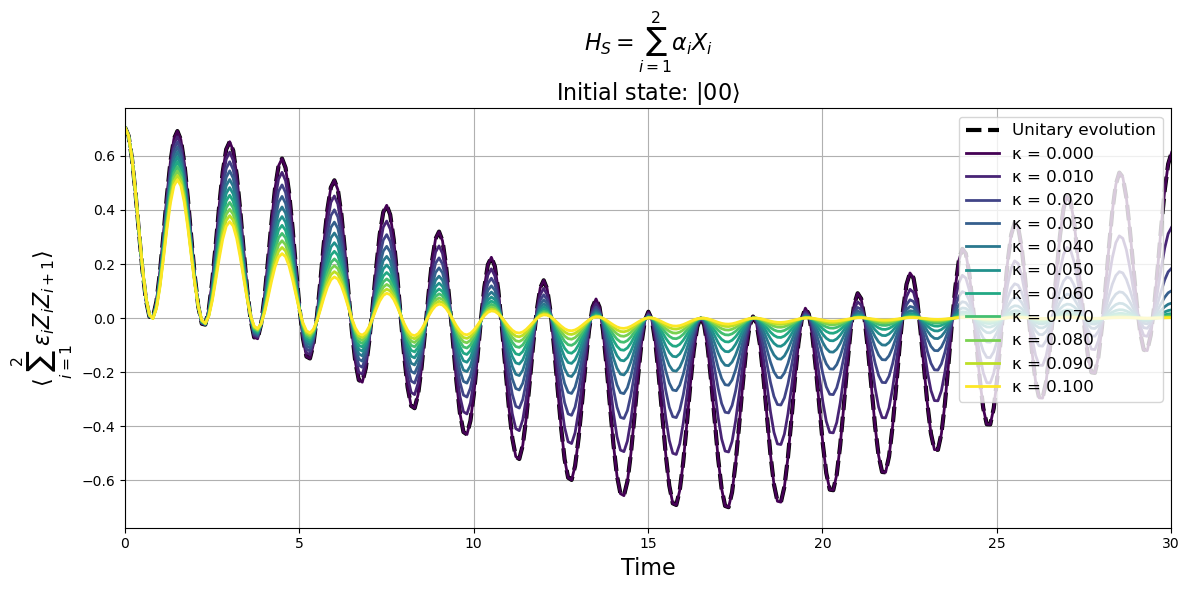

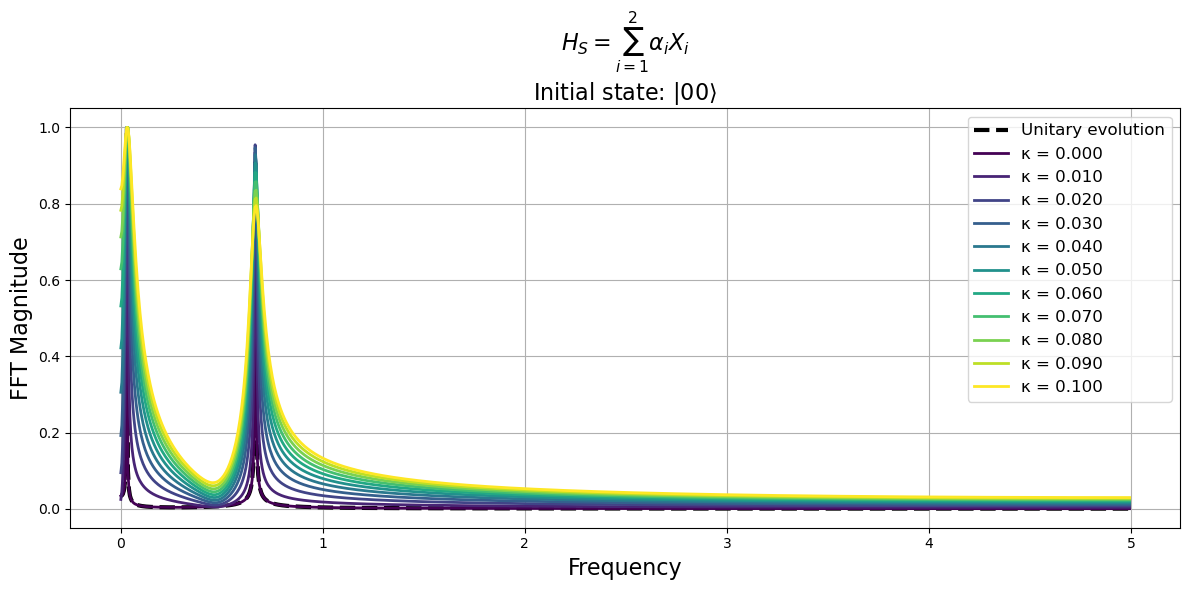

kappa: 0.0, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 0
kappa: 0.001, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.002, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.003, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.004, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.005, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.006, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.007, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.008, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.009000000000000001, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.01, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.011, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.012, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.013000000000000001, Relative Error: 0.07% , num_qubits: 3, Hamiltonian: 0
kappa: 0.014, Relativ

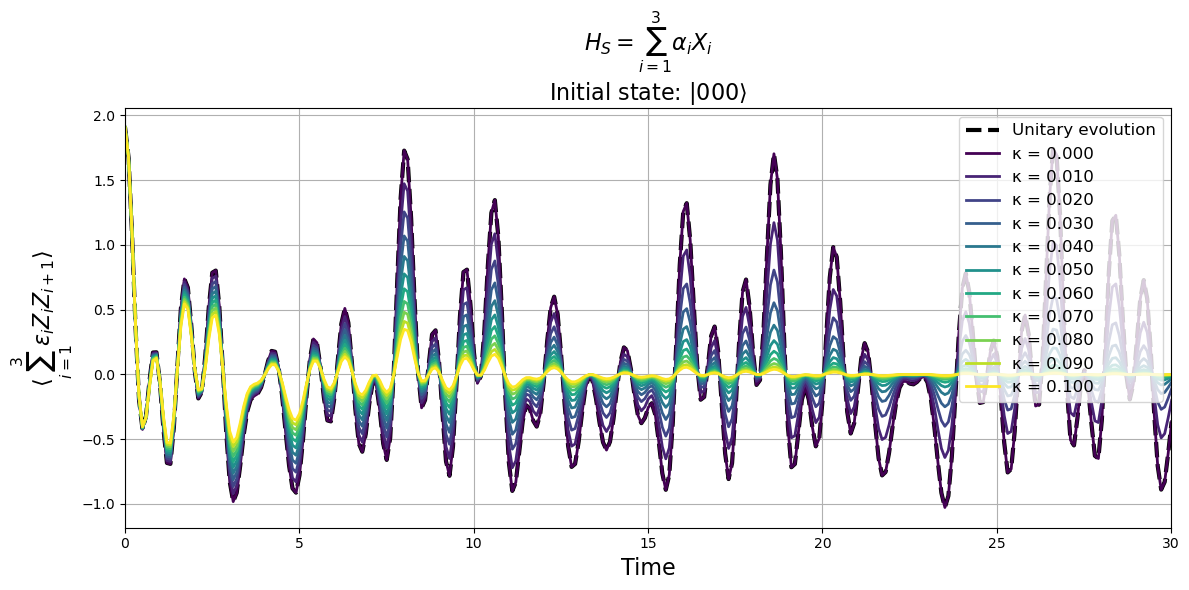

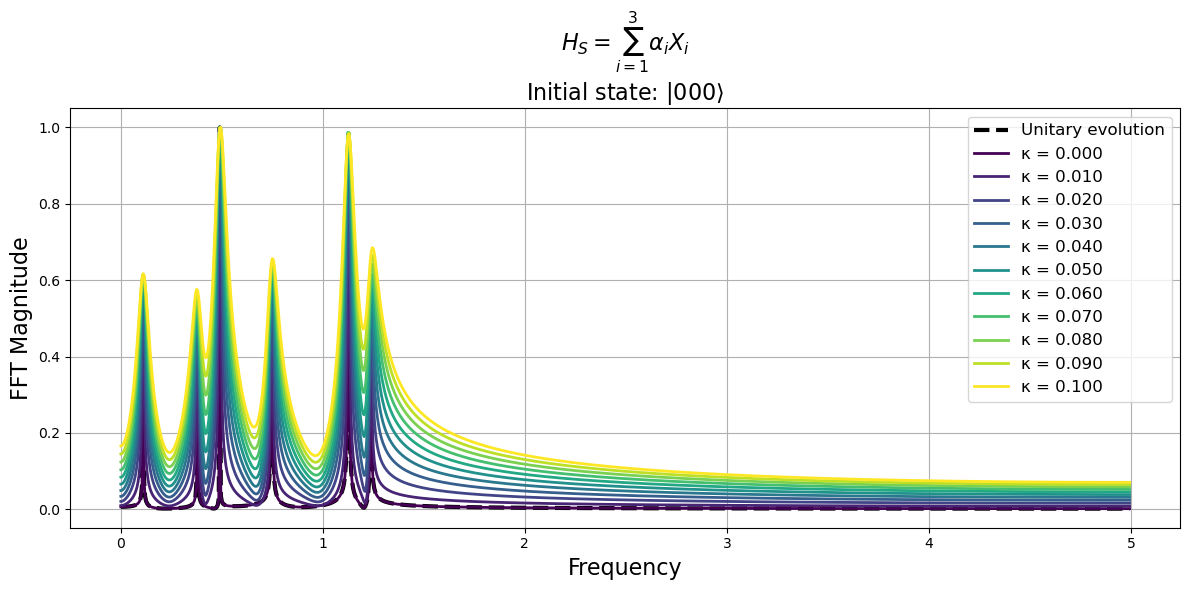

kappa: 0.0, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.001, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.002, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.003, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.004, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.005, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.006, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.007, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.008, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.009000000000000001, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.01, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.011, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.012, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.013000000000000001, Relative Error: 0.00% , num_qubits: 3, Hamiltonian: 1
kappa: 0.014, Relativ

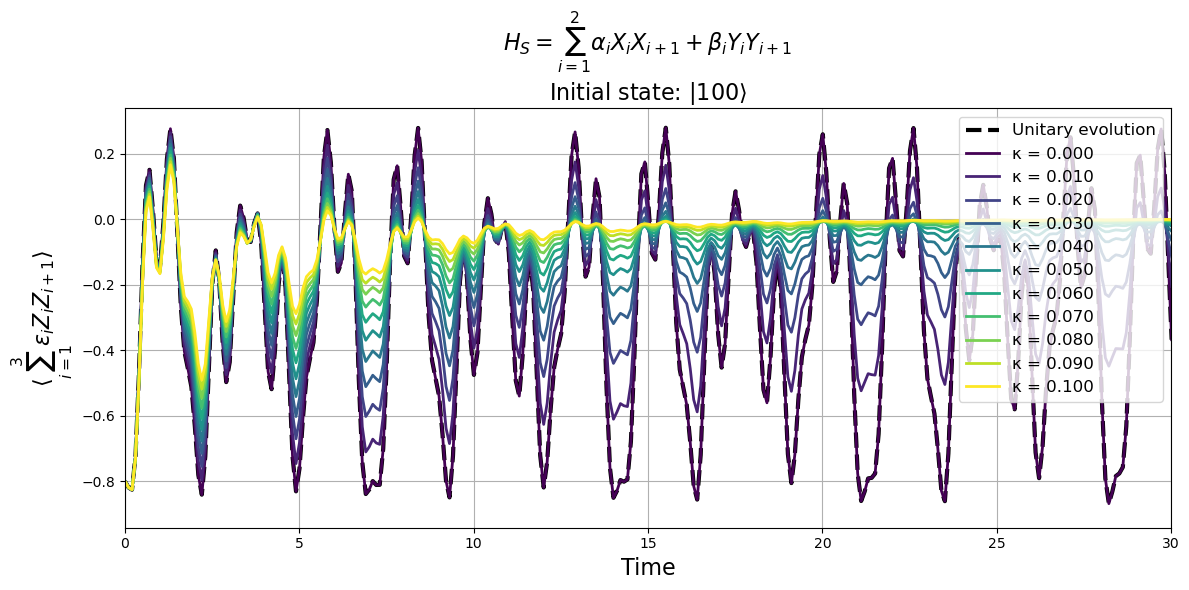

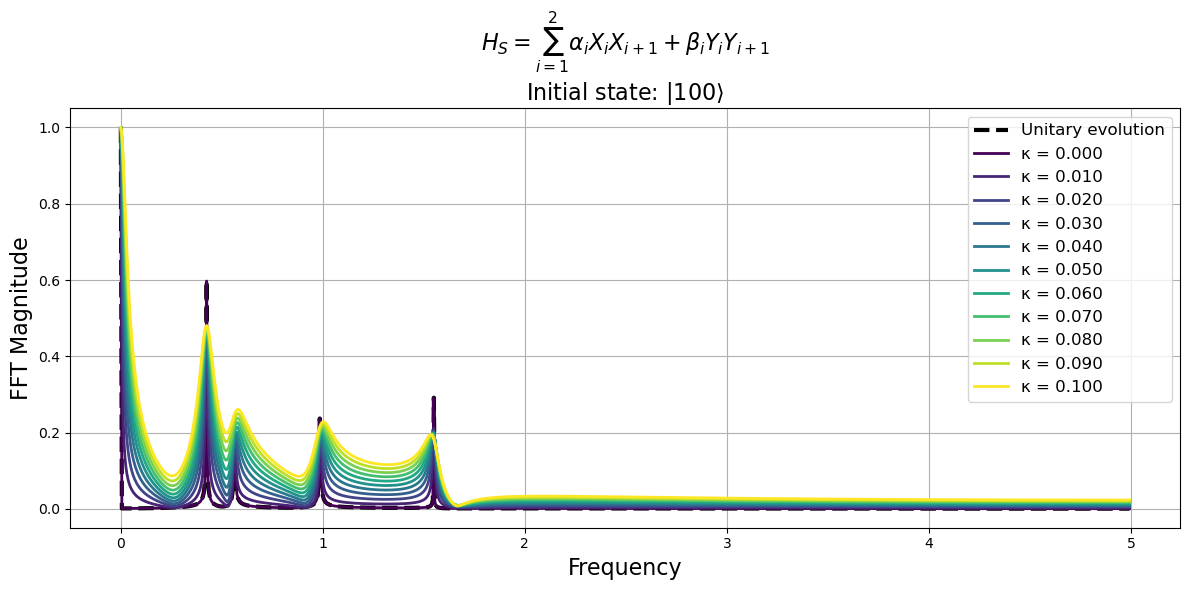

kappa: 0.0, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.001, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.002, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.003, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.004, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.005, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.006, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.007, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.008, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.009000000000000001, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.01, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.011, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.012, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.013000000000000001, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 0
kappa: 0.014, Relativ

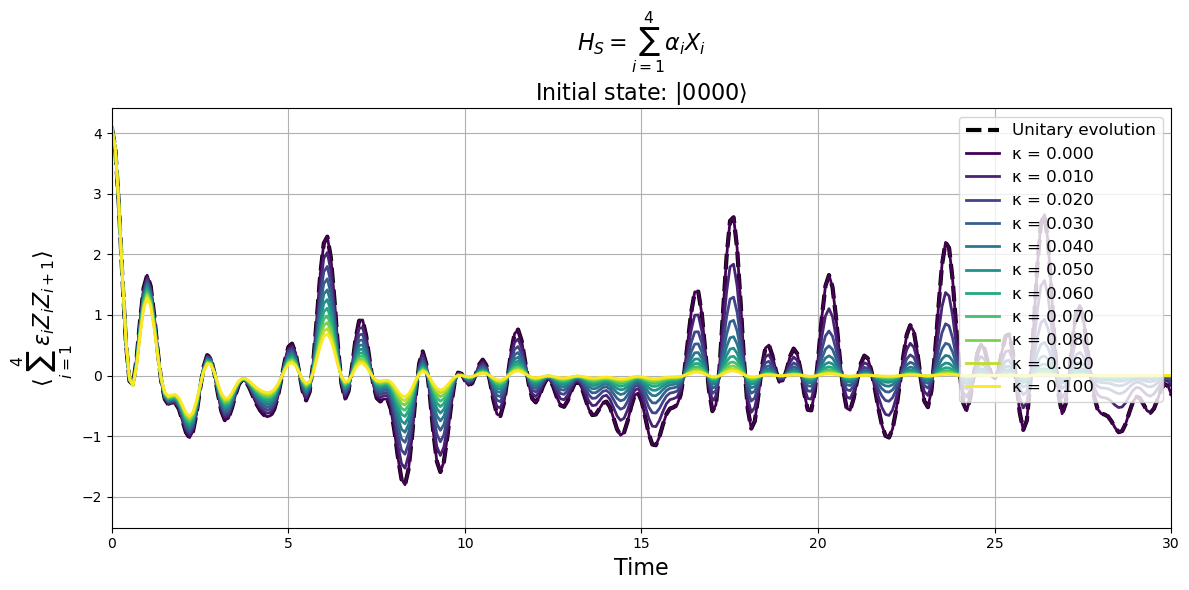

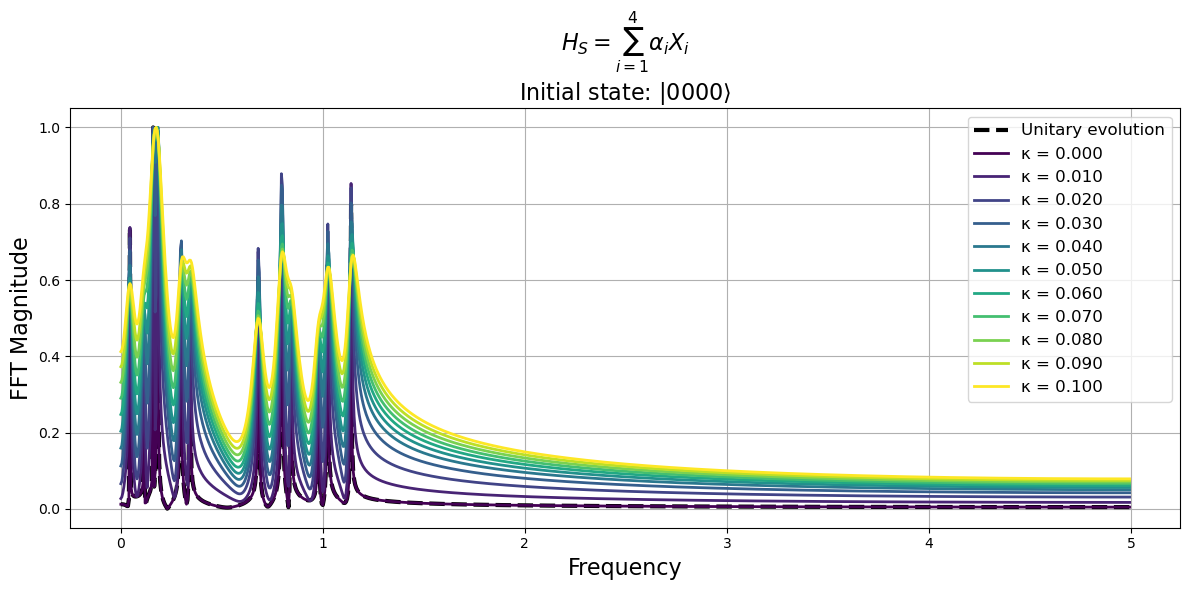

kappa: 0.0, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 1
kappa: 0.001, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 1
kappa: 0.002, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 1
kappa: 0.003, Relative Error: 0.00% , num_qubits: 4, Hamiltonian: 1
kappa: 0.004, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.005, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.006, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.007, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.008, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.009000000000000001, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.01, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.011, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.012, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.013000000000000001, Relative Error: 0.06% , num_qubits: 4, Hamiltonian: 1
kappa: 0.014, Relativ

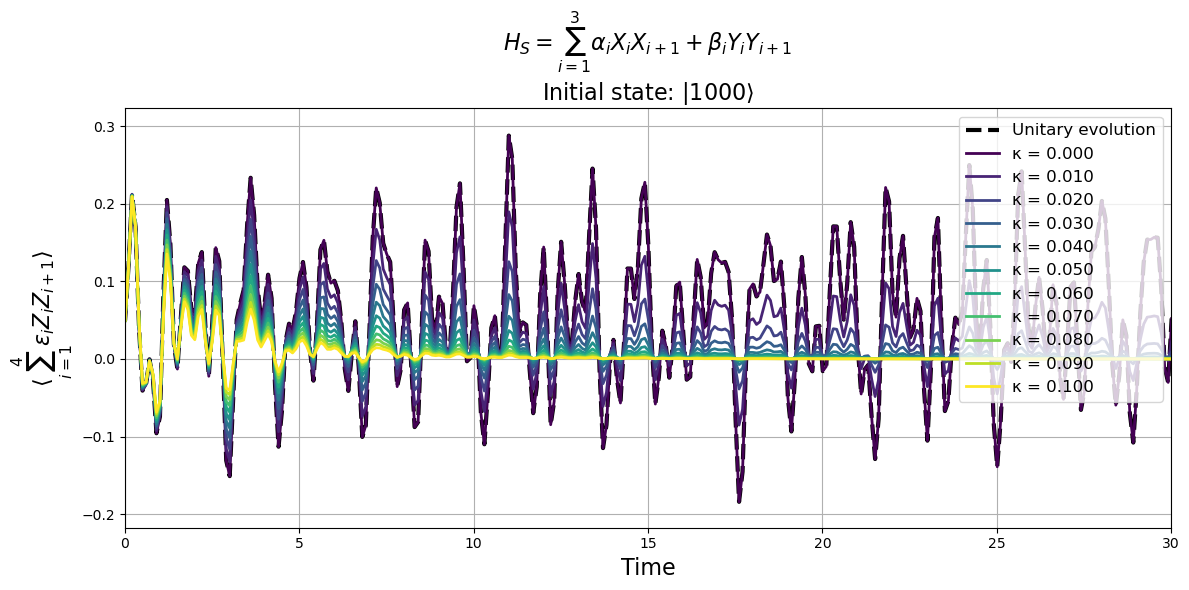

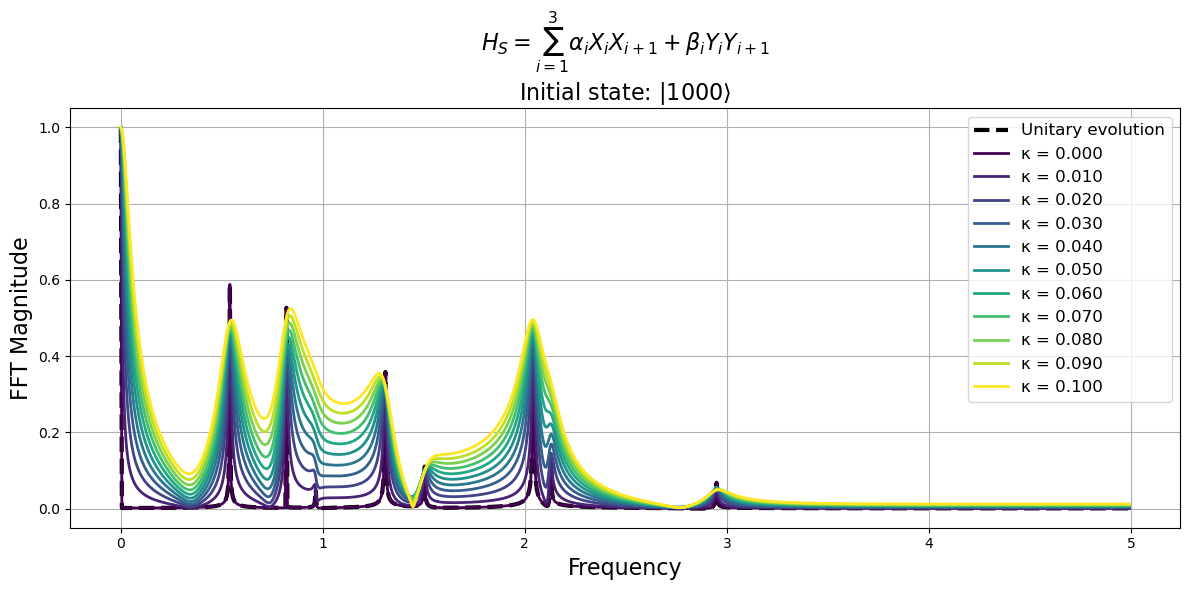

kappa: 0.0, Relative Error: 0.00% , num_qubits: 5, Hamiltonian: 0
kappa: 0.001, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.002, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.003, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.004, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.005, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.006, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.007, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.008, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.009000000000000001, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.01, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.011, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.012, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 0
kappa: 0.013000000000000001, Relative Error: 1.38% , num_qubits: 5, Hamiltonian: 0
kappa: 0.014, Relativ

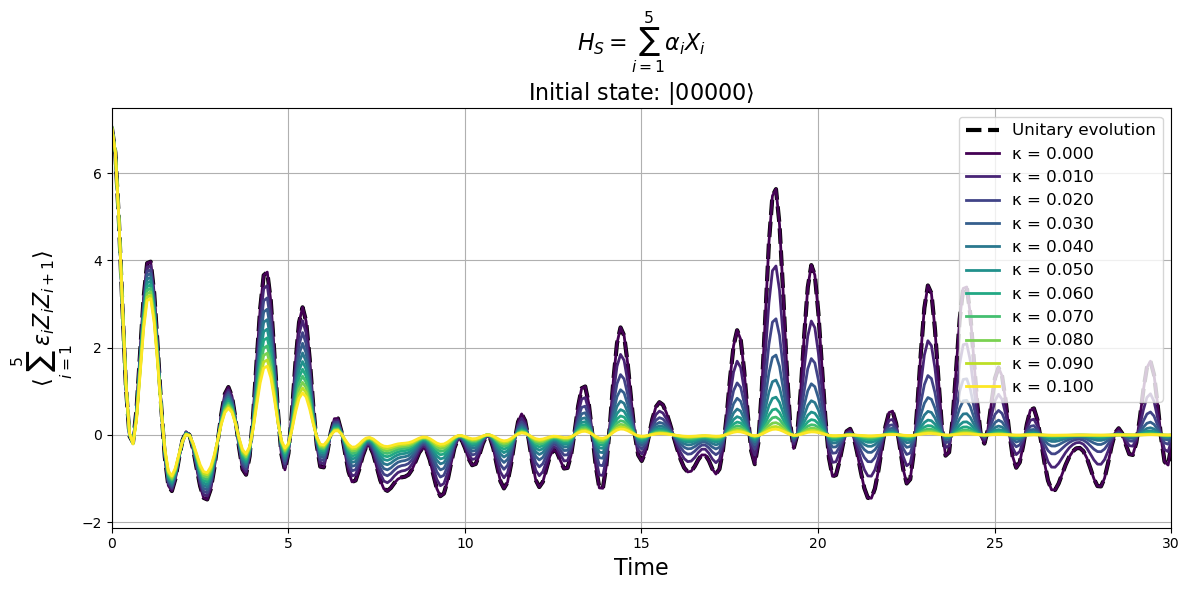

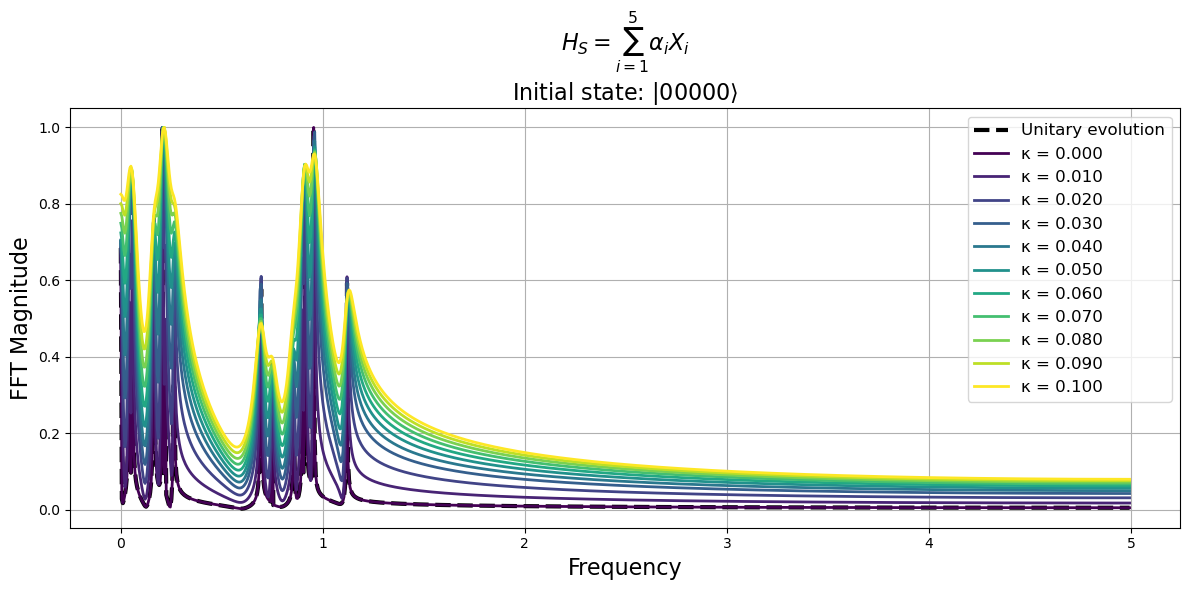

kappa: 0.0, Relative Error: 0.00% , num_qubits: 5, Hamiltonian: 1
kappa: 0.001, Relative Error: 0.00% , num_qubits: 5, Hamiltonian: 1
kappa: 0.002, Relative Error: 0.00% , num_qubits: 5, Hamiltonian: 1
kappa: 0.003, Relative Error: 0.01% , num_qubits: 5, Hamiltonian: 1
kappa: 0.004, Relative Error: 0.29% , num_qubits: 5, Hamiltonian: 1
kappa: 0.005, Relative Error: 0.29% , num_qubits: 5, Hamiltonian: 1
kappa: 0.006, Relative Error: 0.11% , num_qubits: 5, Hamiltonian: 1
kappa: 0.007, Relative Error: 0.12% , num_qubits: 5, Hamiltonian: 1
kappa: 0.008, Relative Error: 0.12% , num_qubits: 5, Hamiltonian: 1
kappa: 0.009000000000000001, Relative Error: 0.12% , num_qubits: 5, Hamiltonian: 1
kappa: 0.01, Relative Error: 0.18% , num_qubits: 5, Hamiltonian: 1
kappa: 0.011, Relative Error: 0.22% , num_qubits: 5, Hamiltonian: 1
kappa: 0.012, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 1
kappa: 0.013000000000000001, Relative Error: 0.24% , num_qubits: 5, Hamiltonian: 1
kappa: 0.014, Relativ

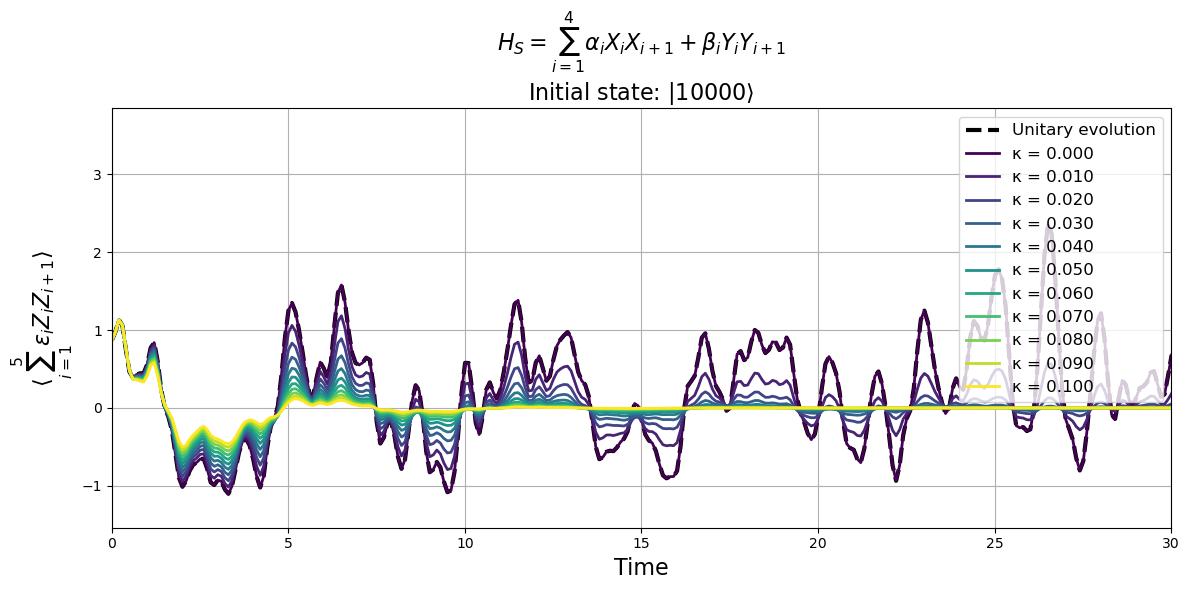

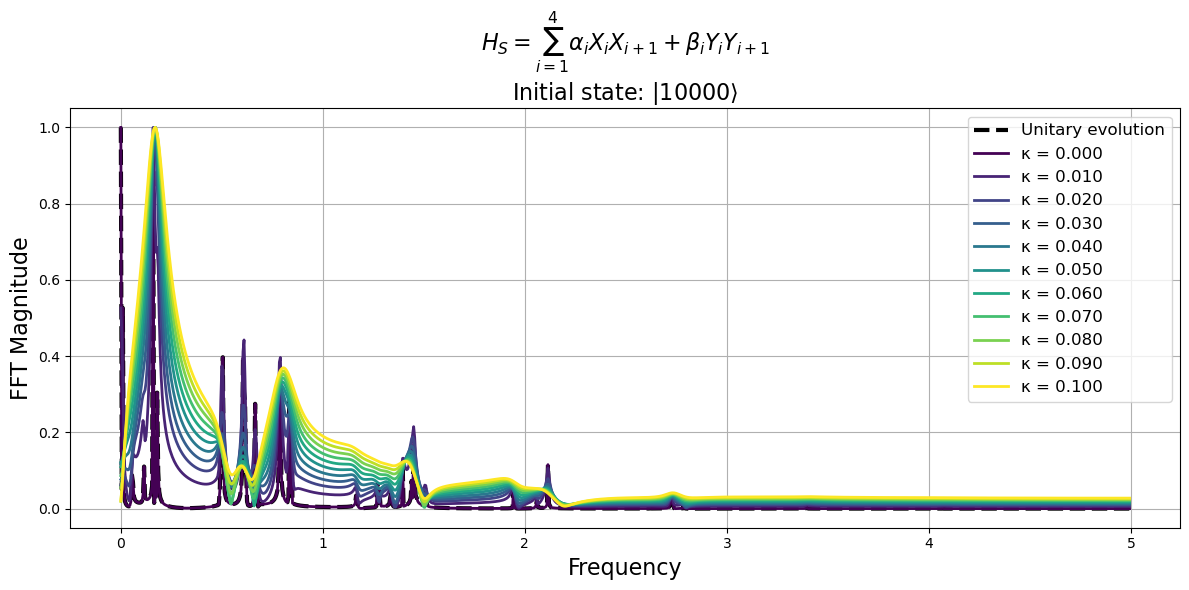

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import os
import itertools
# Fix random seed for reproducibility
seed = 102
np.random.seed(seed)

# General parameters
tlist = np.linspace(0, 200, 2000)
save_base_path = fr"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\c_ops\multioperator\f{seed}"
os.makedirs(save_base_path, exist_ok=True)

import numpy as np
from scipy.signal import savgol_filter, find_peaks
selected_indices = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90,100,101]

import numpy as np
from scipy.signal import find_peaks

def peak_frequency(freqs, fft_vals, height=0.01 , distance=10):
    """
    Returns only the frequencies corresponding to local maxima in the normalized FFT magnitude.

    Parameters:
    freqs (np.ndarray): Array of frequency values (Hz).
    fft_vals (np.ndarray): Array of corresponding FFT values (can be complex).
    height (float, optional): Minimum normalized height (0-1) of peaks to consider.
    distance (int, optional): Minimum number of samples between peaks.

    Returns:
    np.ndarray: Frequencies where local maxima occur, unsorted.
    """
    # Normalize the FFT magnitudes
    abs_fft = np.abs(fft_vals)
    normalized_fft = abs_fft / np.max(abs_fft)
    
    # Find peaks - only need to call find_peaks once
    peaks_idx, _ = find_peaks(normalized_fft, height=height, distance=distance)
    
    return freqs[peaks_idx]

def match_by_leading_digits(peaks1, peaks2, digits=2):
    """
    Match peaks1 -> peaks2 by leading digits and exponent, with flexibility:
    1. First try with `digits` significant digits.
    2. If some peaks are unmatched, try with 1 significant digit.
    3. If still unmatched, allow ±1 difference in leading digits.
    Returns list of (p1, p2) matched pairs.
    """
    def key_sig_exp(x, d):
        if x == 0:
            return ('0'*d, 0)
        s = f"{abs(x):.{d+6}e}"  # scientific notation with extra precision
        mantissa_str, exp_str = s.split('e')
        mantissa = mantissa_str.replace('.', '')[:d]
        exponent = int(exp_str)
        return (mantissa, exponent)

    def try_match(pks1, pks2, d):
        # Basic exact matching by mantissa + exponent
        idx_map = {}
        for i, p2 in enumerate(pks2):
            idx_map.setdefault(key_sig_exp(p2, d), []).append((i, p2))

        matches = []
        used = set()
        unmatched1 = []
        for p1 in pks1:
            key = key_sig_exp(p1, d)
            if key in idx_map:
                for i, p2 in idx_map[key]:
                    if i not in used:
                        matches.append((p1, p2))
                        used.add(i)
                        break
                else:
                    unmatched1.append(p1)
            else:
                unmatched1.append(p1)
        return matches, unmatched1, used

    # 1. Try initial digits
    matches, unmatched1, used2 = try_match(peaks1, peaks2, digits)

    if unmatched1:
        # 2. Retry with 1 significant digit
        extra_matches, unmatched1, used2_extra = try_match(unmatched1, [p2 for i,p2 in enumerate(peaks2) if i not in used2], 1)
        matches.extend(extra_matches)
        used2.update(used2_extra)

    if unmatched1:
        # 3. Allow ±1 difference in first digit of mantissa (for remaining unmatched)
        remaining2 = [p2 for i,p2 in enumerate(peaks2) if i not in used2]
        for p1 in unmatched1:
            m1, e1 = key_sig_exp(p1, 1)
            found = False
            for i, p2 in enumerate(remaining2):
                m2, e2 = key_sig_exp(p2, 1)
                # Check same exponent and mantissa differs by ±1 in integer value
                if e1 == e2 and abs(int(m1) - int(m2)) <= 1:
                    matches.append((p1, p2))
                    remaining2.pop(i)
                    found = True
                    break
            if not found:
                # optionally append None to indicate unmatched
                matches.append((p1, None))

    return matches

def minimal_relative_error(peaks1, peaks2,matches):
    relative_error_avg = 0
    if not matches:
        n1, n2 = len(peaks1), len(peaks2)
        # Use the Hungarian algorithm (optimal assignment) for longer or unequal lists
        n = max(n1, n2)
        # Create square cost matrix with padded dummy values (cost = large)
        cost_matrix = np.full((n, n), fill_value=1e6)
        for i in range(n1):
            for j in range(n2):
                denom = abs(peaks2[j]) if abs(peaks2[j]) > 1e-6 else 1e-6  # avoid division by zero
                cost_matrix[i, j] = (abs(peaks1[i] - peaks2[j]) / denom) * 100  # percentage error

        # Apply Hungarian algorithm to find the minimal total error assignment
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        relative_errors = [cost_matrix[i, j] for i, j in zip(row_ind, col_ind) if i < n1 and j < n2]
        relative_error_avg = np.mean(relative_errors)
        return relative_error_avg
    else:
        # Calculate the average relative error for matched pairs
        for u, v in matches:
            if v is None:
                continue
            aux = (abs(u - v) / abs(v)) * 100
            relative_error_avg += aux
        return relative_error_avg/len(matches)

kappas = np.linspace(0, 0.1, num=101)

for num_qubits in [2,3,4,5]:
        # Be careful in this code because if alpha and beta are too similar the expected value remain constant over time
    alpha_list = np.random.uniform(1,5,num_qubits)
    beta_list = np.random.uniform(1, 5, num_qubits)
    min_value = np.min(np.concatenate((alpha_list, beta_list)))

    # Normalize both arrays so that the smallest entry across both becomes 1
    alpha= alpha_list / min_value
    beta = beta_list / min_value
    alpha_1= alpha_list / np.min(alpha_list)
    # Operator constructors
    def build_op(op_qubit, pos):
        ops = [qeye(2) for _ in range(num_qubits)]
        ops[pos] = op_qubit
        return tensor(ops)

    X_ops = [build_op(sigmax(), i) for i in range(num_qubits)]
    Y_ops = [build_op(sigmay(), i) for i in range(num_qubits)]
    Z_ops = [build_op(sigmaz(), i) for i in range(num_qubits)]

    # Observable
    J = np.zeros((num_qubits, num_qubits))
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            J[i][j] = np.random.uniform(0.3, 1.0)
            J[j][i] = J[i][j]  # ensure symmetry

    # Build the 2-local observable: sum_{i<j} J_ij * Z_i Z_j
    observable_op_1 = sum(J[i][j] * Z_ops[i] * Z_ops[j]
                        for i in range(num_qubits)
                        for j in range(i+1, num_qubits))
    

    # Build the 2-local observable: sum_{i<j} J_ij * Z_i Z_j
    observable_op_2 = sum(J[i][j] * X_ops[i] * X_ops[j]
                        for i in range(num_qubits)
                        for j in range(i+1, num_qubits))
    # Optional but recommended: wrap explicitly
    observable_op_1 = Qobj(observable_op_1)
    observable_op_2 = Qobj(observable_op_2)
    # Hamiltonians
    Hs_1 = sum(alpha_1[i] * X_ops[i] for i in range(num_qubits))
    Hs_2 = sum(alpha[i] * X_ops[i] * X_ops[i+1] + beta[i] * Y_ops[i] * Y_ops[i+1] for i in range(num_qubits - 1))
    #Hs_3 = sum(alpha[i] * Z_ops[i] for i in range(num_qubits))

    # Initial states
    zero_state = tensor([basis(2, 0) for _ in range(num_qubits)])
    one_state = tensor([basis(2, 1)] + [basis(2, 0) for _ in range(1, num_qubits)])
    psi_1 = zero_state.unit()
    psi_2 = one_state.unit()
    #psi_3 = (zero_state + one_state).unit()
    for i in range(2):

        if num_qubits == 1:
            continue
        results_list = []
        ket_zero = "0" * num_qubits
        ket_mixed = "1" + "0" * (num_qubits - 1)

        # Hamiltonian and initial state setup
        if i == 0:
            Hs = Hs_1
            state = psi_1
            observable_op = observable_op_1
            bath_basis = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_i X_i$' '\n'
                r'Initial state: $|%s\rangle$' % (num_qubits, ket_zero)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_iZ_{i+1} \rangle$' % num_qubits

        elif i == 1:
            if num_qubits == 2:
               continue
            Hs = Hs_2
            state = psi_2
            observable_op = observable_op_1
            bath_basis = Z_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_{i} X_i X_{i+1} + \beta_{i} Y_i Y_{i+1}$' '\n'
                r'Initial state: $|%s\rangle$' % (num_qubits - 1, ket_mixed)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i Z_iZ_{i+1} \rangle$' % num_qubits

        else:
            Hs = Hs_3
            def get_initial_state(num_qubits):
                if num_qubits == 1:
                    return (basis(2, 0) + basis(2, 1)).unit()  # |+⟩
                else:
                    # Producto de |+⟩ en cada qubit
                    plus = (basis(2, 0) + basis(2, 1)).unit()
                    return tensor([plus] * num_qubits)
            state = get_initial_state(num_qubits)
            observable_op = observable_op_2
            bath_basis = X_ops
            ham_title = (
                r'$H_S = \sum_{i=1}^{%d} \alpha_i Z_i$' '\n'
                r'Initial state: $\dfrac{1}{\sqrt{2}} (|%s\rangle + |%s\rangle)$' 
                % (num_qubits, ket_zero, ket_mixed)
            )
            obs_label = r'$\langle \sum_{i=1}^{%d} \epsilon_i X_iX_{i+1} \rangle$' % num_qubits
            

        # Unitary evolution (no collapse)
        result_unitary = sesolve(Hs, state, tlist)
        observable_vals_unitary = [expect(observable_op, st) for st in result_unitary.states]
        fft_unitary = np.abs(np.fft.fft(observable_vals_unitary))

        freqs_unitary = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
        mask_pos = freqs_unitary >= 0
        fft_unitary = fft_unitary[mask_pos]
        freqs_unitary = freqs_unitary[mask_pos]
        fft_unitary = fft_unitary / np.max(fft_unitary)

        # Plot time evolution
        plt.figure(figsize=(12, 6))
        plt.plot(tlist, observable_vals_unitary, 'k--', lw=3, label='Unitary evolution')

        fft_kappas = []
        freqs_kappas = []
        labels_kappas = []

        for idx_kappa, kappa_val in enumerate(kappas):
            # Collapse operators scaled by coupling strength

            c_ops = [np.sqrt(kappa_val) * op for op in bath_basis]

            result = mesolve(Hs, state, tlist, c_ops)

            observable_vals = [expect(observable_op, st) for st in result.states]

            if idx_kappa in selected_indices:
                color = plt.cm.viridis(idx_kappa / (len(kappas) - 1))
                plt.plot(tlist, observable_vals, lw=2, label=f'κ = {kappa_val:.3f}', color=color)

            # FFT
            
            energy_fft = np.abs(np.fft.fft(observable_vals))
            freqs = np.fft.fftfreq(len(tlist), tlist[1]-tlist[0])
            mask_pos = freqs >= 0
            freqs = freqs[mask_pos]
            energy_fft = energy_fft[mask_pos]
            energy_fft = energy_fft / np.max(energy_fft)


            fft_kappas.append(energy_fft)
            freqs_kappas.append(freqs)
            labels_kappas.append(f'κ = {kappa_val:.3f}')

            freq_peak = peak_frequency(freqs, energy_fft)

            
            freq_peak_unitary =peak_frequency(freqs_unitary, fft_unitary)
            
            if len(freq_peak) > 0 and len(freq_peak_unitary) > 0:
                freq_peak = np.sort(freq_peak)
                freq_peak_unitary = np.sort(freq_peak_unitary)
                matches = match_by_leading_digits(freq_peak, freq_peak_unitary, digits=2)
                relative_error_avg = minimal_relative_error(freq_peak, freq_peak_unitary,matches)
            else:
                relative_error_avg = 100




            if relative_error_avg >= 100:
                relative_error_avg = 100
                print("Error: Relative error is 100% or more, breaking the loop.")

            print(f"kappa: {kappa_val}, Relative Error: {relative_error_avg:.2f}% , num_qubits: {num_qubits}, Hamiltonian: {i}")
            results_list.append({
                "kappa": kappa_val,
                "Hamiltonian": ham_title,
                "freq_peak": freq_peak,
                "freq_peak_unitary": freq_peak_unitary,
                "relative_error": relative_error_avg
            })

        # Save time evolution figure
        plt.title(ham_title, fontsize=16)
        plt.xlim(0, 30)
        plt.xlabel('Time', fontsize=16)
        plt.ylabel(obs_label, fontsize=16)
        plt.grid(True)
        plt.legend(loc='upper right', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()

        # Plot FFT comparison
        plt.figure(figsize=(12, 6))
        plt.plot(freqs_unitary, fft_unitary, 'k--', lw=3, label='Unitary evolution')

        for idx, (energy_fft, freqs, label) in enumerate(zip(fft_kappas, freqs_kappas, labels_kappas)):
            if idx in selected_indices:
                color = plt.cm.viridis(idx / (len(fft_kappas) - 1))
                plt.plot(freqs, energy_fft, lw=2, label=label, color=color)

        plt.title(ham_title, fontsize=16)
        plt.xlabel('Frequency', fontsize=16)
        plt.ylabel('FFT Magnitude', fontsize=16)
        plt.grid(True)
        plt.legend(loc='upper right', fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_base_path, f'fft_{i}_{num_qubits}.pdf'))
        plt.show()
        plt.close()

        csv_path = os.path.join(save_base_path, f'df_{num_qubits}_{i}.csv')

        df = pd.DataFrame(results_list)

        if os.path.exists(csv_path):
            df_old = pd.read_csv(csv_path)
            # Concatenar y eliminar duplicados usando solo la columna 'alpha'
            df_combined = pd.concat([df_old, df], ignore_index=True)
            df_combined.drop_duplicates(subset=['kappa'], inplace=True)
            df_combined.to_csv(csv_path, index=False)
        else:
            df.to_csv(csv_path, index=False)

        styled_df = (df.style
                    .set_caption(f"Results for {num_qubits} Qubits")
                    .set_table_styles([{
                        'selector': 'thead th',
                        'props': [('background-color', '#1F77B4'), ('color', 'white')]
                    }]))
        display(styled_df)


### Plotting the results

<>:70: SyntaxWarning: invalid escape sequence '\k'
<>:70: SyntaxWarning: invalid escape sequence '\k'
C:\Users\jalej\AppData\Local\Temp\ipykernel_15120\2890905312.py:70: SyntaxWarning: invalid escape sequence '\k'
  plt.xlabel("$\kappa$")


File not found: C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\c_ops\multioperator\f102\df_1_0.csv


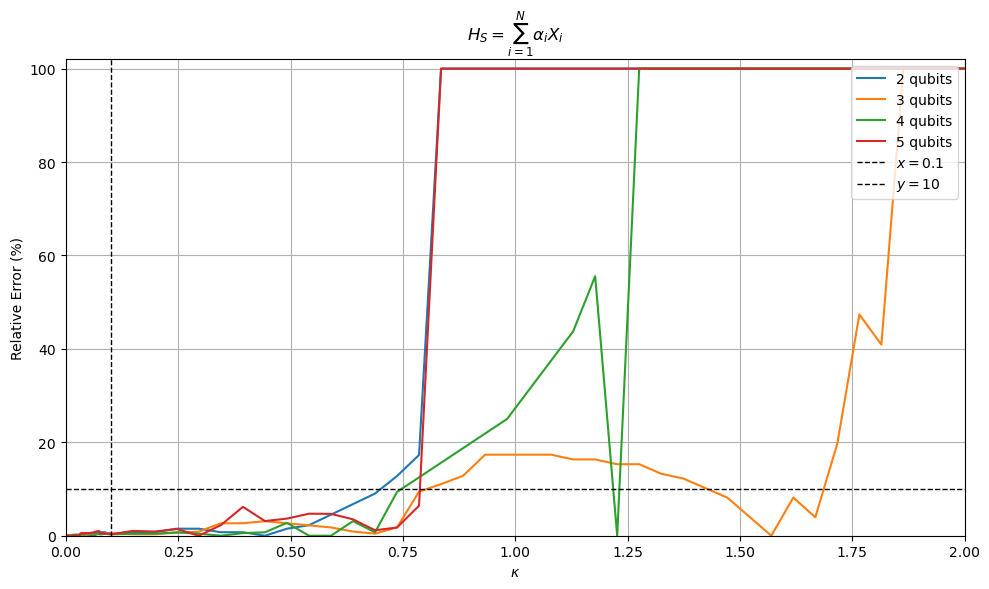

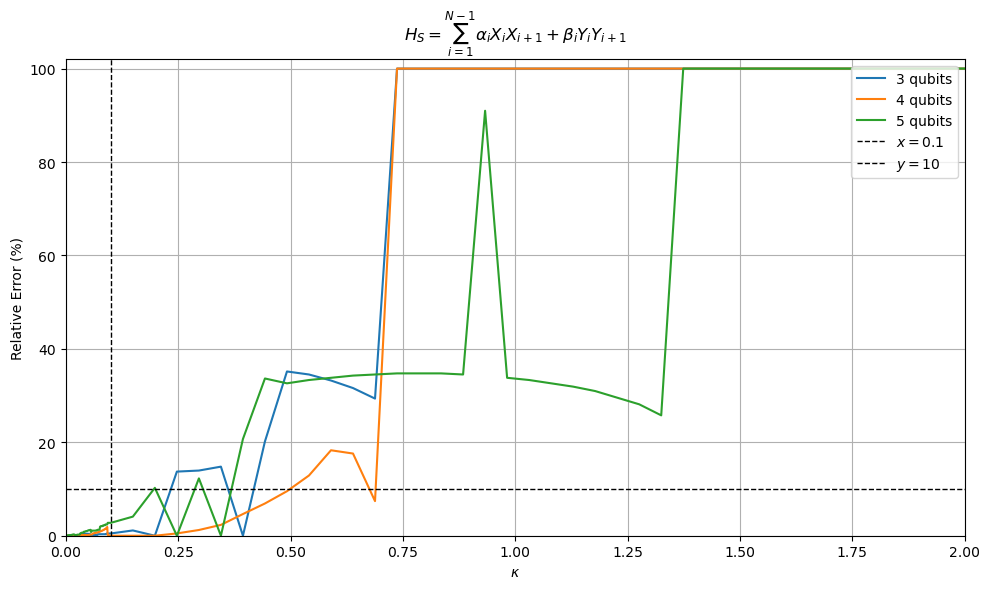

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
seed = 102
# Base folder where files are located
base_path = fr"C:\Users\jalej\OneDrive\Escritorio\Documentos\Master\Segundo Cuatri\TFM\To Lianao\Graphs\analysis\c_ops\multioperator\f{seed}"

# i from 1 to 5, j from 0 to 2
i_range = range(1, 6)
j_range = range(2)

# Desired maximum kappa for plots
max_kappa = 2# or adjust to your expected max
num_points = 100  # resolution for interpolation / extension

# Initialize grouped data storage
grouped_data = {j: [] for j in j_range}

# Read all relevant files
for j in j_range:
    for i in i_range:
        if j == 1 and i == 1:
            continue
        if j == 1 and i == 2:
            continue
        filename = f"df_{i}_{j}.csv"
        file_path = os.path.join(base_path, filename)

        try:
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue

            df = pd.read_csv(file_path)

            if df.shape[1] < 2:
                print(f"File {filename} has insufficient columns.")
                continue

            x = df.iloc[:, 0]
            y = df.iloc[:, -1]

            # Replace None, NaN, or values > 100 with 100
            y_clean = y.fillna(100)
            y_clean = np.where((y_clean > 100) | (pd.isnull(y_clean)), 100, y_clean)

            # Ensure values extend to max_kappa with y=100
            if x.max() < max_kappa:
                x_extended = np.linspace(x.min(), max_kappa, num_points)
                y_extended = np.interp(x_extended, x, y_clean, left=100, right=100)
                x = x_extended
                y_clean = y_extended

            grouped_data[j].append((x, y_clean, f"{i} qubits"))

        except Exception as e:
            print(f"Could not read file {file_path}: {e}")

# Plotting
for j in j_range:
    plt.figure(figsize=(10, 6))
    if not grouped_data[j]:
        print(f"No data for j = {j}")
        continue

    for x, y, label in grouped_data[j]:
        plt.plot(x, y, label=label)

    plt.xlabel("$\kappa$")
    plt.ylabel("Relative Error (%)")
    if j == 0:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i X_i$')
    elif j == 1:
        plt.title(r'$H_S = \sum_{i=1}^{N-1} \alpha_i X_i X_{i+1} + \beta_i Y_i Y_{i+1}$')
    else:
        plt.title(r'$H_S = \sum_{i=1}^{N} \alpha_i Z_i$')
    plt.axvline(x=0.1, color='black', linestyle='--', linewidth=1, label=r'$x=0.1$')

    plt.axhline(y=10, color='black', linestyle='--', linewidth=1, label=r'$y=10$')
    plt.legend(loc='upper right')
    plt.xlim(0, max_kappa)
    plt.ylim(0, 102)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(base_path, f'output_multi_c_ops_{j}.pdf'))
    plt.show()
